# **Comprehensive NLP Analysis of Top Global News Headlines (2018-Present)**

This document presents a **thorough Natural Language Processing (NLP) analysis** of global news headlines spanning from **2018 to the present**. The analysis demonstrates proficiency in fundamental NLP techniques, preprocessing steps, and insightful visualizations that extract meaningful patterns from textual data.

**Disclaimer**: The data is the **MOST CLICKED**, **TOP HEADLINES** of every day between 2019 May to 2023 May. Our findings might reflect if there is more to a News headlines click rate other than its inherit content, and if not, which content has been most influential, what has been talked about the most, our sentiment to various entities as a society and every other thing that is implied with this. 

---

## **Table of Contents**

1. [**Introduction**](#introduction)
2. [**Data Exploration**](#data-exploration)
3. [**Data Preprocessing**](#data-preprocessing)
   - [Text Normalization](#text-normalization)
   - [Tokenization](#tokenization)
   - [Stop Words Removal](#stop-words-removal)
   - [Token Unification and Renormalizing Entities](#token-unification)
   - [Part-of-Speech Tagging](#part-of-speech-tagging)
   - [Lemmatization](#lemmatization)
   - [Named Entity Recognition](#named-entity-recognition)
4. [**Feature Extraction**](#feature-extraction)
   - [Bag of Words](#bag-of-words)
   - [TF-IDF Vectorization](#tf-idf-vectorization)
   - [Word Embeddings](#word-embeddings)
5. [**Sentiment Analysis**](#sentiment-analysis)
   - [Monthly Sentiment Trends](#monthly-sentiment-trends)
   - [Year-over-Year Sentiment Comparison](#year-over-year-sentiment-comparison)
6. [**Topic Modeling**](#topic-modeling)
   - [Latent Dirichlet Allocation](#latent-dirichlet-allocation)
   - [Topic Evolution Over Time](#topic-evolution-over-time)
7. [**Entity Analysis**](#entity-analysis)
   - [Most Mentioned Entities](#most-mentioned-entities)
   - [Entity Co-occurrence Networks](#entity-co-occurrence-networks)
8. [**Time Series Analysis**](#time-series-analysis)
   - [Headline Complexity Over Time](#headline-complexity-over-time)
   - [Topic Seasonality](#topic-seasonality)
9. [**Conclusion**](#conclusion)

---

## **Introduction**

This analysis explores a rich dataset of **news headlines** from **2019 to 2023**, covering **25 of the world's most influential news headlines**. The dataset is structured with **dates** in the first column followed by 25 headlines from each source. By applying various **NLP techniques**, we aim to uncover patterns, trends, and insights that reveal how global news discourse has evolved over this significant period, from sentimental analysis of each day and year to reoccuring patterns of entities and how their sentiment on the media has changed over the years, or as i like to call it, the sentimental derivative. 

---

## **Data Exploration**

Let's begin by loading the dataset and exploring its basic structure:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
import string
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set visualization styles
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (12, 8)

# Load the dataset
news_df = pd.read_csv('datasets/WorldNewsData.csv')

# Display basic information
print(f"Dataset shape: {news_df.shape}")



# Check the first few rows


# Convert Date column to datetime (note capital "D")
# Since the date format is "May 01, 2018", we need to parse it correctly
news_df['Date'] = pd.to_datetime(news_df['Date'], format="%b %d, %Y")

# Display the date range
print(f"\nTime period: {news_df['Date'].min()} to {news_df['Date'].max()}")

# Create a year-month column for temporal analysis
news_df['year_month'] = news_df['Date'].dt.to_period('M')

# Create a column for the year
news_df['year'] = news_df['Date'].dt.year

# Create a column for the month
news_df['month'] = news_df['Date'].dt.month

# Sample a few rows
print("\nSample data:")
news_df.head()

Dataset shape: (1859, 26)

Time period: 2018-05-01 00:00:00 to 2023-04-30 00:00:00

Sample data:


,Date,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,...,Top19,Top20,Top21,Top22,Top23,Top24,Top25,year_month,year,month
0,2018-05-01,"North Korea to open its sky, South Korean medi...",The Mueller probe ain't ending anytime soon,BRAND NEW: 2018 – Renault Alpine A110 – Start-...,The story of the Midwestern innocent let loose...,Mattis tempers optimistic outlook on Afghanist...,Facebook is taking on Tinder with new dating f...,OECD chief says Greece deserves debt relief af...,Facebook to launch dating service,U.N. could help Myanmar gather evidence of cri...,...,My Email Newsletter of Curated Marketing Content,Mueller asks for 2 more months before Flynn se...,Mueller asks for 2 more months before Flynn se...,Canada to tack a carbon price of at least 11 c...,Kanye West: 'The class war is one of the reaso...,Michael Stewart/WireImage Kylie Jenner simply ...,For first time health ministry will regulate d...,2018-05,2018,5
1,2018-05-02,'What have they got to fear? ' Trump threatens...,"Best Garage Heater Reviews incuding electric, ...",Apple just fueled everyone's biggest fear abou...,Google accused of using GDPR to impose unfair ...,Man died accidentally after climbing behind wo...,When the coveted Palme d’Or trophy is awarded ...,"""Borders are Illegal?"" Tucker Carlson Vs Dumb ...","Mark Zuckerberg says it will take 3 years to ""...",The 8 Best Cooling Pillows You Can Buy,...,House Republicans nominate Donald Trump for No...,UK's May faces local election losses as key Br...,Whynter ICM-15LS Ice Cream Maker Review,"Abbas says Jews’ behavior, not anti-Semitism, ...",House Republicans nominate Trump for Nobel Pea...,"Tyson Foods the largest U.S. meat processor, h...",Questions linger about how Melania Trump score...,2018-05,2018,5
2,2018-05-03,Hollywood isn’t simply churning out crummy rem...,Iran's foreign minister: US has ‘consistently ...,Rihanna covers the June 2018 problem of Vogue ...,U.S. soldiers are secretly fighting Saudi Arab...,Canadian MP Bob Saroya took trip to China paid...,2017 Best Black Friday and Cyber Monday Mattre...,"NBC, ABC Say Trump Lawyer Michael Cohen Was No...",South Korean janitor may keep gold bars found ...,Last chance: UN warns Cambodia over failing de...,...,Marketing’s Customer Obsession Imperative | C3...,Ex-Trump aide Michael Caputo warns: Mueller Ru...,11-Year-Old Girl With Autism Wouldn’t Talk In ...,Richard Corkery/NY Each day Information throug...,What Makes the Brand Stand Out?,UK drones in Syria using controversial 'vacuum...,"High fruit diet could help women conceive, stu...",2018-05,2018,5
3,2018-05-04,Donald Trump says London hospital is 'like a w...,German seat on UN Security Council likely as I...,Gang Used Drone Swarm To Thwart FBI Hostage Raid,How Many Carbs Should You Eat Per Day To Lose ...,Russian Troll Farm Goes After Mueller’s Files,Israeli soldiers singing in Persian for Irania...,Labor Day 2017 Sales on Memory Foam Mattresses...,"How a Chinese city turned all its 16,000 buses...",Jamie Acourt arrested in Spain over suspected ...,...,How to Increase Sales by Encouraging Mobile Sp...,China’s schooling Trump on the art of the delay,Abi Ofarim ist tot,The 8 Best Snow Boots For Women,Kerry quietly seeking to salvage Iran deal he ...,Trump's Syria aid freeze hits 'White Helmets' ...,US slams Turkey over population transfers in A...,2018-05,2018,5
4,2018-05-05,Missing teen’s mom implores Canada to take not...,William and Kate release new pictures of Princ...,MEGHANS BROTHER SENDS PRINCE HARRY A SECRET LE...,Australia: Free whooping cough vaccine will be...,Shock and Thaw—Alaskan Sea Ice Just Took a Ste...,Giuliani: Trump is 'committed to' regime chang...,Pakistan: Polio eradication teams will visit d...,"Aides to Donald Trump, the US president, hired...",Donald Trump’s NRA speech causes anger in U.K....,...,Revealed: Trump team hired spy firm for ‘dirty...,A Simple Way to Improve a Billion Lives: Eyegl...,Dutch cop requests removal of Holocaust memori...,Montreal couple agree to submit

## **Data Preprocessing**

 There are some duplicate months in the original data, (like October 2020) Lets start by removing the duplicates and clearing the dataset. Next, let's create a function to combine all headlines for each day into a single text corpus, and a list that contains the headlines separately, so we can analyze both on per day basis and per headline. This distinction will be useful later on.

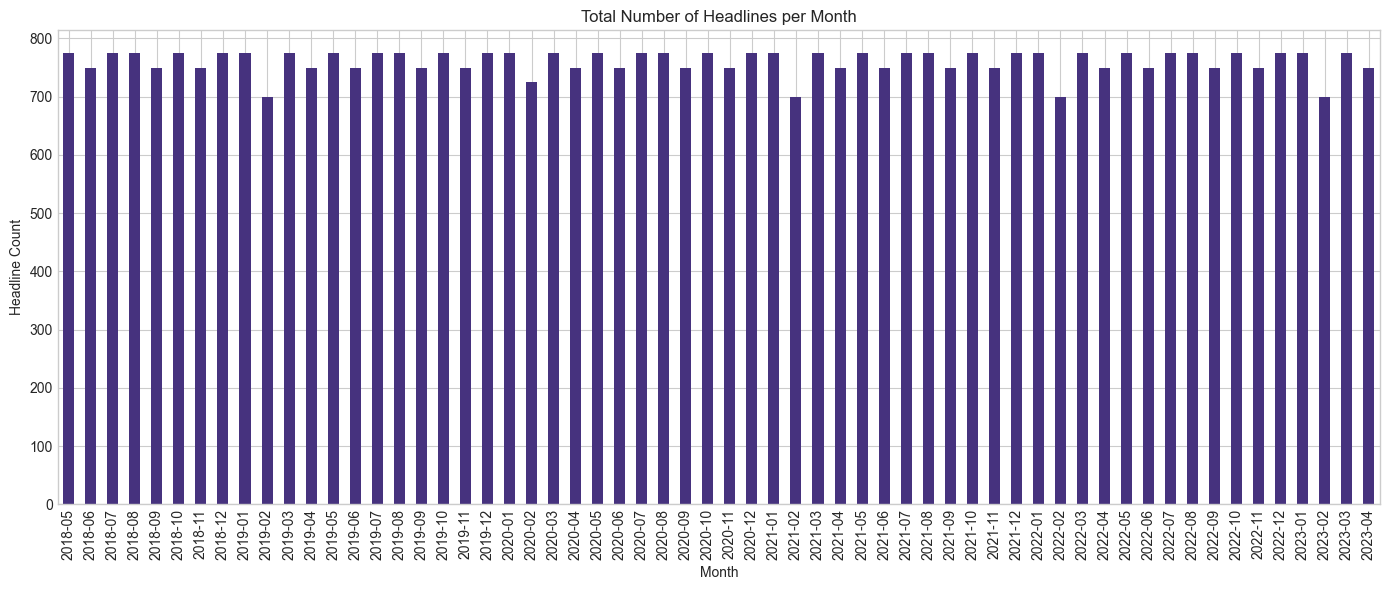

In [2]:
# ensuring 'Date' is in datetime format
news_df['Date'] = pd.to_datetime(news_df['Date'])

# drop duplicates
news_df = news_df.drop_duplicates(subset='Date', keep='first')

def combine_headlines(row):
    # combine all headlines in a row into a single string for easy day based tokenization later
    headlines = []
    # start from column 'Top1' through 'Top25'
    for col in news_df.columns[1:26]:  # Skip the Date column, include only Top1-Top25
        if pd.notna(row[col]):
            headlines.append(str(row[col]))
    return ' '.join(headlines)

# Apply the function to create a new column with combined headlines
news_df['combined_headlines'] = news_df.apply(combine_headlines, axis=1)

headlines_per_month = news_df.groupby(news_df['Date'].dt.to_period('M')).size() * 25

plt.figure(figsize=(14, 6))
headlines_per_month.plot(kind='bar')
plt.title('Total Number of Headlines per Month')
plt.xlabel('Month')
plt.ylabel('Headline Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Create a new column that stores the list of non-null individual headlines (Top1–Top25)
def get_separate_headlines(row):
    """Return a list of non-empty individual headlines"""
    return [str(row[col]) for col in news_df.columns[1:26] if pd.notna(row[col])]

news_df['separate_headlines'] = news_df.apply(get_separate_headlines, axis=1)

# Count number of headlines (not assuming all 25 filled)
news_df['headline_count'] = news_df['separate_headlines'].apply(len)

# Group by month and sum all actual headlines
separate_headlines_per_month = news_df.groupby(news_df['Date'].dt.to_period('M'))['headline_count'].sum()


# **Text Normalization**

Now our data looks clear and no unusual spikes showing duplicate data. Before diving into the deeper depths of data processing, we need to normalize our dataset. Normalization is like organizing a dataset, we need to remove symbols, lowercase everything, remove numbers, non-UNICODE letters, and some other things based on what we need, we might need to remove words like "in, and, out, of" (which are called stopwords) because they might skew the data by introducing unnecessary bias. We actually took our first step already by removing duplicates! We will do a general normalization here and might use more in depth techniques like lemmatization or stemming based on our needs. 

Next, lets start by defining a new function normalize_text() to do every normalization step we desire to the dataset and store it in a variable.

In [3]:
import re
import string
import html
import contractions
import spacy
import pandas as pd

# Load spaCy model (blank English model to avoid over-processing)
nlp = spacy.blank("en")

def safe_expand_contractions(text):
    """Safely expand contractions, handling non-English text"""
    if not isinstance(text, str) or not text.strip():
        return text
    
    # Skip processing if text contains non-ASCII characters that might cause issues
    if any(ord(c) > 127 for c in text):
        return text  # Return original text without expansion
    
    # Process contractions for English text
    try:
        return contractions.fix(text)
    except Exception as e:
        print(f"Contraction expansion error: {e} in text: {text[:50]}...")
        return text  # Return original text on error

def normalize_text(text):
    if not isinstance(text, str) or not text.strip():
        return ""
        
    # Step 1: Pre-replace acronyms with more comprehensive dict
    acronyms = {"U.N.": "UN", "U.S.": "US", "E.U.": "EU", "u.s.": "US", 
                "U.K.": "UK", "N.Y.": "NY", "L.A.": "LA"}
    for k, v in acronyms.items():
        text = text.replace(k, v)
    
    # Step 2: Expand contractions with safe handling
    text = safe_expand_contractions(text)
    
    # Step 3: Lowercase
    text = text.lower()
    
    # Step 4: Remove possessive 's or 's (improved patterns)
    text = re.sub(r"\b(\w+)['']\s*s\b", r"\1", text)  # Handles standard possessives
    text = re.sub(r"\b(\w+s)['']\b", r"\1", text)     # Handles plural possessives
    
    # Step 5: Remove remaining apostrophes (shouldn't be needed, for edge cases)
    text = re.sub(r"(\w+)'(\w+)", r"\1\2", text)
    text = re.sub(r"(\w+)'", r"\1", text)
    
    # Step 6: Remove punctuation and smart quotes/dashes
    punct_chars = string.punctuation + "–—''""•"
    text = re.sub(f"[{re.escape(punct_chars)}]", "", text)
    
    # Step 7: HTML unescape and entity removal (combined)
    text = html.unescape(text)
    text = re.sub(r'&[a-zA-Z#0-9]+;', '', text)  # Remove any remaining entities
    
    # Step 8: Remove any non-English characters and emojis
    # Note: This will remove numbers as per original code
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Step 9: Remove any remaining single s (from cases like "60's")
    text = re.sub(r'\b[sS]\b', '', text)
    
    # Step 10: Collapse whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text.strip()

# Make sure the dataframe is properly filtered before processing
news_df = news_df[
    news_df['Date'].notna() & 
    news_df['combined_headlines'].notna() & 
    (news_df['combined_headlines'].str.strip() != '')
]

# Apply normalization
news_df['normalized_text'] = news_df['combined_headlines'].apply(normalize_text)

# This one is the headlines divided individually instead of a per-day basis of concatenation.
# As stated, this might be useful later on to track the sentimental derivative
# of specific entities. This line applies our normalize function to every h in lst,
# or specifically every headline in every row and column.
news_df['normalized_separate'] = news_df['separate_headlines'].apply(
    lambda lst: [normalize_text(h) for h in lst if h]  # Added check for empty headlines
)

# Display a sample of normalized text
print("Original headline:")
print(news_df['combined_headlines'].iloc[0][:400])
print("\nNormalized headline:")
print(news_df['normalized_text'].iloc[0][:400])
print("\nOriginal Separated headline:")
print(news_df['separate_headlines'].iloc[0][:10])
print("\nNormalized Separated headline:")
print(news_df['normalized_separate'].iloc[0][:10])

Original headline:
North Korea to open its sky, South Korean media reports. The Mueller probe ain't ending anytime soon BRAND NEW: 2018 – Renault Alpine A110 – Start-UP &amp; Loud Sound! The story of the Midwestern innocent let loose in the big city has been a trope in successful comedies from “Tales of the City” (1993) to “Girls” (2012). “Sweetbitter,” a new, six-episode series on Starz, takes another naif, doe-eye

Normalized headline:
north korea to open its sky south korean media reports the mueller probe aint ending anytime soon brand new renault alpine a startup amp loud sound the story of the midwestern innocent let loose in the big city has been a trope in successful comedies from tales of the city to girls sweetbitter a new sixepisode series on starz takes another naif doeeyed tess ella purnell and sets her loose in the n

Original Separated headline:
['North Korea to open its sky, South Korean media reports.', "The Mueller probe ain't ending anytime soon", 'BRAND NEW: 2018 – 

We are getting there, Now its time for tokenization! 
# **Tokenization**

 Tokenization is the process of breaking text into individual words or tokens,<br> 
 This and the rest are the reason we are using python 3.11 instead of 3.13, simply put, spacy is not supported in 3.13 and it is crucial. <br>
 We can actually work around this and use nltk, but spacy is far superior, but it is much slower and takes more space and processing power. <br>
 We can run the code below in a split second, but there will be few cells later on that will take minutes of processing. even with best optimizations. <br>


 # Why are we Tokenizing?

We tokenize because "just using words" isn’t enough — raw text is messy, ambiguous, and inconsistent. Machines are determinate and certain. <br>

Tokenization is the process of breaking text into meaningful units (usually words, subwords, or sentences), and it's a critical first step in making text machine-readable for NLP tasks. <br>

"New Orleans" is two words but one concept.

"tokenization" is "token" + "###ization", and we feed them separately into a machine. <br> 
They use statistical analysis models to guess the next word, structure of the next word, in sum; the next sentence, then in total, the next paragraph. Tokens streamline this approach. <br>


 We stored the normalized dataset in the variable "normalized_text", lets play around with it, and tokenize! You will get the hang of it better. 

1. COMBINED TEXT TOKENS (first 40):
['north', 'korea', 'to', 'open', 'its', 'sky', 'south', 'korean', 'media', 'reports', 'the', 'mueller', 'probe', 'ai', 'nt', 'ending', 'anytime', 'soon', 'brand', 'new', 'renault', 'alpine', 'a', 'startup', 'amp', 'loud', 'sound', 'the', 'story', 'of', 'the', 'midwestern', 'innocent', 'let', 'loose', 'in', 'the', 'big', 'city', 'has']

2. SEPARATE HEADLINE TOKENS (first 5 headlines):
 Headline 1: ['north', 'korea', 'to', 'open', 'its', 'sky', 'south', 'korean', 'media', 'reports']
 Headline 2: ['the', 'mueller', 'probe', 'are', 'not', 'ending', 'anytime', 'soon']
 Headline 3: ['brand', 'new', 'renault', 'alpine', 'a', 'startup', 'amp', 'loud', 'sound']
 Headline 4: ['the', 'story', 'of', 'the', 'midwestern', 'innocent', 'let', 'loose', 'in', 'the', 'big', 'city', 'has', 'been', 'a', 'trope', 'in', 'successful', 'comedies', 'from', 'tales', 'of', 'the', 'city', 'to', 'girls', 'sweetbitter', 'a', 'new', 'sixepisode', 'series', 'on', 'starz', 'takes', '

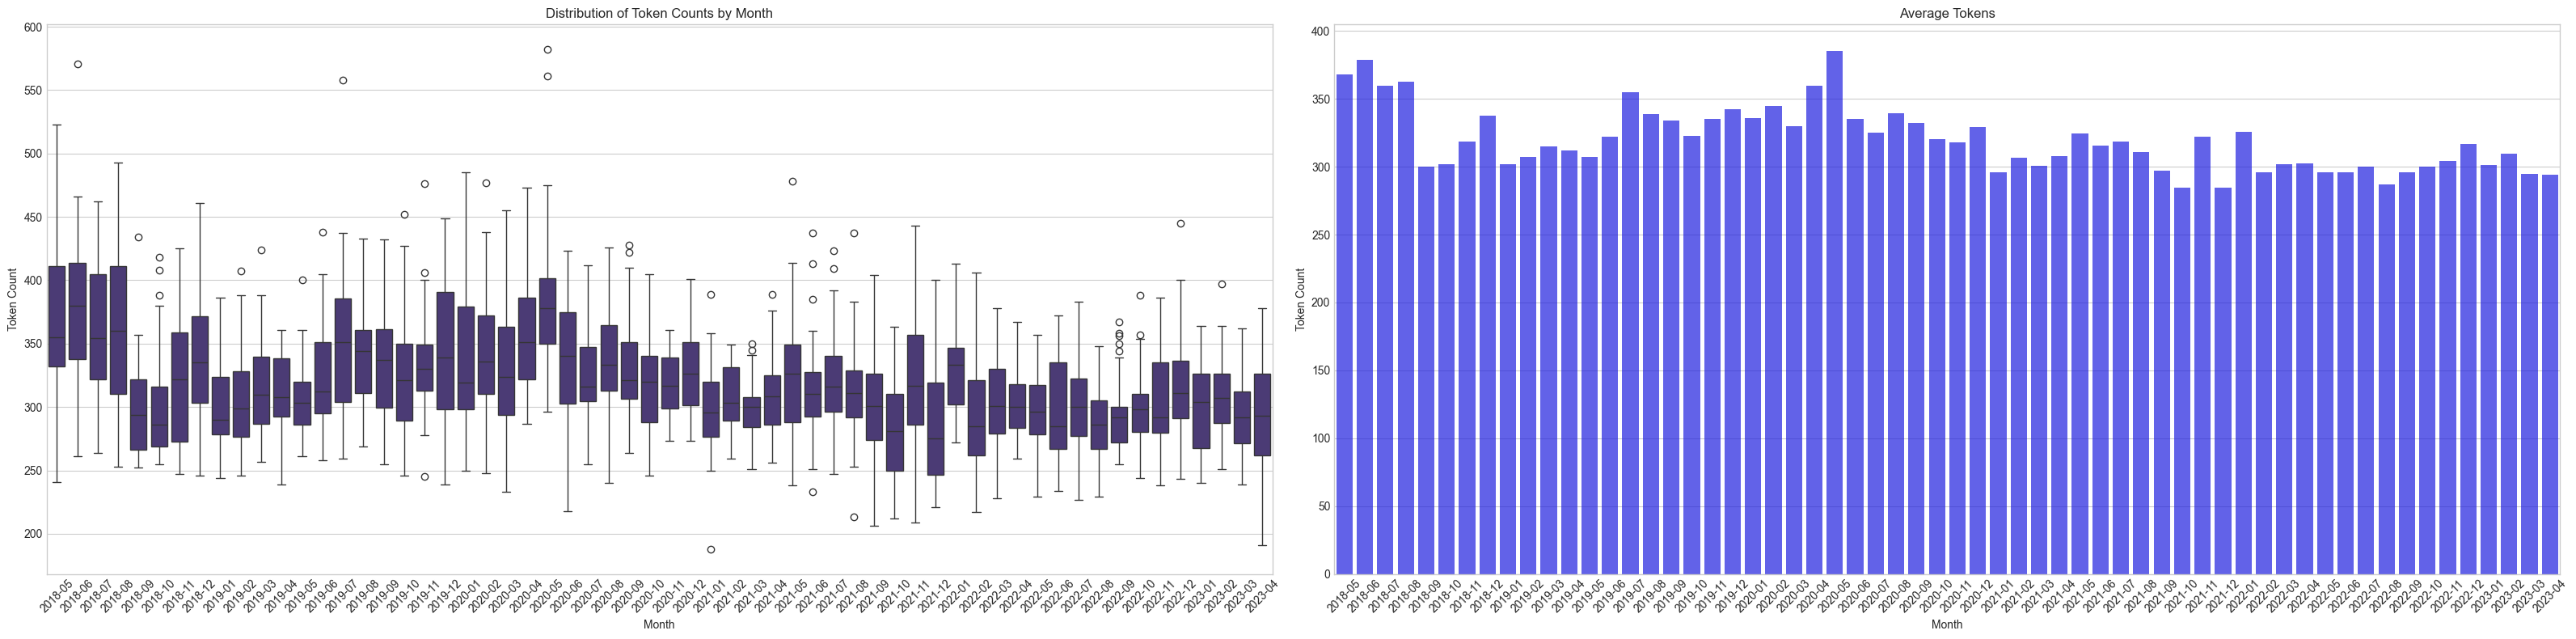

In [4]:
import spacy
from spacy.tokenizer import Tokenizer
from spacy.lang.en.stop_words import STOP_WORDS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize spaCy with custom tokenizer settings
nlp = spacy.blank("en")
tokenizer = nlp.tokenizer

# Add special cases to the tokenizer
special_cases = [{"ORTH": "covid19"}, {"ORTH": "covid-19"}]
for case in special_cases:
    nlp.tokenizer.add_special_case(case["ORTH"], [case])

def tokenize_text(text):
    """Splits text into individual words using spaCy's tokenizer with error handling"""
    if not text or not isinstance(text, str):
        return []
    try:
        tokens = tokenizer(text)
        # Return only non-empty tokens (optional: filter stop words)
        # Uncomment the stop words filter if needed
        # return [token.text for token in tokens if token.text.strip() and token.text.lower() not in STOP_WORDS]
        return [token.text for token in tokens if token.text.strip()]
    except Exception as e:
        print(f"Tokenization error: {e} in text: {text[:50]}...")
        return []

# Function for batch processing
def batch_tokenize(texts, batch_size=1000):
    return [tokenize_text(text) for text in texts]
    

news_df['tokens'] = batch_tokenize(news_df['normalized_text'])

def tokenize_headline_list(headline_list):
    if not headline_list:
        return []
    return [tokenize_text(h) for h in headline_list]

news_df['separate_tokens'] = news_df['normalized_separate'].apply(tokenize_headline_list)

# Display samples of all three token types
print("1. COMBINED TEXT TOKENS (first 40):")
print(news_df['tokens'].iloc[0][:40])

print("\n2. SEPARATE HEADLINE TOKENS (first 5 headlines):")
sample_headlines = news_df['separate_tokens'].iloc[0][:5] # Get first 5 headlines from first row
for i, headline_tokens in enumerate(sample_headlines):
    print(f" Headline {i+1}: {headline_tokens}")

# Token statistics with error handling
news_df['token_count'] = news_df['tokens'].apply(len)
news_df['avg_token_length'] = news_df['tokens'].apply(
    lambda x: np.mean([len(token) for token in x]) if x else 0
)

# separate_headlines total token count per day
news_df['separate_token_count'] = news_df['separate_tokens'].apply(
    lambda lst: sum(len(tokens) for tokens in lst) if lst else 0
)

# compute average word length with error handling
news_df['separate_avg_token_length'] = news_df['separate_tokens'].apply(
    lambda lst: np.mean([len(token) for tokens in lst for token in tokens]) if lst and any(tokens for tokens in lst) else 0
)

# each headline is treated like a sentence here
news_df['separate_sentence_count'] = news_df['normalized_separate'].apply(len)

# graph month column
news_df['Month'] = pd.to_datetime(news_df['Date']).dt.to_period('M').astype(str)

# Display statistics about all three token types
print("\nSTATISTICS SUMMARY:")
print(f"Combined text tokens: {news_df['token_count'].sum():,} total tokens")
print(f"Separate headlines: {news_df['separate_sentence_count'].sum():,} total headlines")
print(f"Separate headline tokens: {news_df['separate_token_count'].sum():,} total tokens")

# Visualization code
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(32, 8))

# Boxplot of token counts by month
sns.boxplot(x='Month', y='token_count', data=news_df, ax=axes[0])
axes[0].set_title('Distribution of Token Counts by Month')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Token Count')
axes[0].tick_params(axis='x', rotation=45)

# Prepare data for grouped bar chart
news_df['separate_avg_tokens'] = news_df['separate_token_count'] / news_df['separate_sentence_count'].clip(lower=1)

monthly_stats = news_df.groupby('Month').agg({
    'token_count': 'mean',
    'separate_token_count': 'mean',
    'separate_avg_tokens': 'mean',
}).reset_index()

# Barplot of average token count by month
sns.barplot(x='Month', y='token_count', data=monthly_stats, ax=axes[1], color='blue', alpha=0.7)
axes[1].set_title('Average Tokens')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Token Count')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

We created 2 columns in our dataset; A combined headlines list where all the headlines of a day is combined into one giant string and then tokenized,  <br>
And a list of lists consisting of headlines turned into tokens. We will mostly be using the separate headlines list, but the combined list will come in handy in one place later on. 

# **Stop Words Removal**
Next, we should tidy up a bit more until we are left with only the meaningful segment of our data in hand. This meaningful segment includes people, places, and everything else that we call entities, while it doesn't include things like "of, on, and, in, the," AND words that dont have any importance in tracking, we care about who or what is being talked about, not the verb they are doing. For example, in the sentence "Donald Trump stated that China should revert all tariffs back or..." We are interested in Donald Trump, China, tariffs, but we are not interested in "that, stated, all, or" . Revert and should can be used for sentiment analysis, so they should stay. We are also allowing some stop words, contrary to the stop word list so that those stop words don't skew the sentiment analysis data. We also clean up apostrophes so we don't get multiple tokens for words like doesn't, or Trump's.

In [5]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

# Load spaCy English model - only if needed for other purposes
# Use blank model if only stopwords are needed to improve performance
nlp = spacy.blank("en")  # Changed from spacy.load to save memory/time

# Base stop words from spaCy
stop_words = STOP_WORDS.copy()

# Add your custom stop words
custom_stops = {
    'says', 'said', 'reuters', 'ap', 'afp', 'report', 'reports', 
    'or', 'stated', 'for', 'new', 'u', 'amp', 'is', 'in', 'news'
}
stop_words.update(custom_stops)

# Keep important stopwords for sentiment analysis
stop_words.difference_update({'not', 'very', 'so', 'should', 'if'})

# Function to remove stopwords with error handling
def remove_stopwords(tokens):
    """Remove stopwords from a token list with error handling"""
    if not tokens:
        return []
    try:
        return [token for token in tokens if token.lower() not in stop_words]
    except Exception as e:
        print(f"Error removing stopwords: {e}")
        return tokens

# Function to process nested lists (one list per headline)
# and DROP any headline that becomes empty after stop-word removal
def remove_stopwords_from_separate_headlines(headline_tokens_list):
    """Process nested token lists and filter empty results"""
    if not headline_tokens_list:
        return []
        
    cleaned_headlines = []
    for tokens in headline_tokens_list:
        filtered = remove_stopwords(tokens)
        if filtered:  # keep only non-empty results
            cleaned_headlines.append(filtered)
    return cleaned_headlines

# Apply the functions - with duplication check
if 'tokens_nostop' not in news_df.columns:
    news_df['tokens_nostop'] = news_df['tokens'].apply(remove_stopwords)

if 'separate_tokens_nostop' not in news_df.columns:
    news_df['separate_tokens_nostop'] = news_df['separate_tokens'].apply(
        remove_stopwords_from_separate_headlines
    )

# Print some statistics
print(f"Original token count: {sum(news_df['tokens'].apply(len)):,}")
print(f"Tokens after stopword removal: {sum(news_df['tokens_nostop'].apply(len)):,}")
percent_reduction = (1 - sum(news_df['tokens_nostop'].apply(len))/sum(news_df['tokens'].apply(len))) * 100
print(f"Reduction: {percent_reduction:.2f}%")

# Check for any empty token lists after stopword removal
empty_token_rows = news_df[news_df['tokens_nostop'].apply(len) == 0]
if not empty_token_rows.empty:
    print(f"\nWarning: {len(empty_token_rows)} rows have empty token lists after stopword removal")

Original token count: 565,813
Tokens after stopword removal: 382,979
Reduction: 32.31%


# **Token Unification** 
If we listed the tokens and how many times they are used, we would see duplicate tokens like covid (2000 uses) and coronavirus (1500 uses). To counter this we create an entity renormalization table of synonyms that will unify some tokens together based on the rules we provide. 

In [6]:
# Synonym map for token normalization
synonym_map = {
    # COVID-related terms
    'covid': 'covid19',
    'covid-19': 'covid19',
    'coronavirus': 'covid19',
    'covid19': 'covid19',
    'corona': 'covid19',  
    'corona-virus': 'covid19',
    'sars-cov-2': 'covid19',
    'sarscov2': 'covid19',

    # US related terms
    'us': 'usa',
    'u.s.': 'usa',
    'u.s.a.': 'usa',
    'united states': 'usa',
    'america': 'usa',
    'american': 'usa',
    'americans': 'usa',

    # UK related terms
    'uk': 'united_kingdom',
    'u.k.': 'united_kingdom',
    'britain': 'united_kingdom',
    'british': 'united_kingdom',

    # Political terms
    'democrat': 'democrats',
    'democratic': 'democrats',
    'republican': 'republicans',
    'gop': 'republicans',
    'hong kong' : 'hong_kong',
    'hong' : 'hong_kong',
    'kong' : 'hong_kong',

    # Politicians
    'biden': 'joe_biden',
    'joe': 'joe_biden',
    'president biden': 'joe_biden',
    
    'trump': 'donald_trump',
    'donald': 'donald_trump',
    'president trump': 'donald_trump',
    
    'putin': 'vladimir_putin',
    'vladimir': 'vladimir_putin',
    'president putin': 'vladimir_putin',
    
    # Common variations
    'govt': 'government',
    'gov': 'government',
    'admin': 'administration',
    'intl': 'international',
    'corp': 'corporation',
    'co': 'company',
    'cos': 'companies',
    'ceo': 'chief_executive_officer',
    'nt' : 'not'
}

# Create case-insensitive mapping for better matching
case_insensitive_map = {k.lower(): v for k, v in synonym_map.items()}

# Enhanced token unification with multi-word phrase handling and error checking
def unify_tokens_with_phrases(tokens, mapping):
    """Normalize tokens using a synonym mapping with multi-word phrase support"""
    if not tokens:
        return []
        
    try:
        normalized_tokens = []
        i = 0
        while i < len(tokens):
            # Check for multi-word phrases (up to 3 words)
            found_match = False
            for n in range(min(3, len(tokens) - i), 0, -1):  # Safe range checking
                if i + n <= len(tokens):
                    phrase = ' '.join(tokens[i:i+n]).lower()
                    if phrase in mapping:
                        normalized_tokens.append(mapping[phrase])
                        i += n
                        found_match = True
                        break
            
            # If no phrase match, just normalize the single token
            if not found_match:
                token_lower = tokens[i].lower()
                normalized_tokens.append(mapping.get(token_lower, tokens[i]))
                i += 1
        
        return normalized_tokens
    except Exception as e:
        print(f"Error in token unification: {e} for tokens: {tokens[:5]}...")
        return tokens

# Function to safely process nested headline tokens
def unify_headline_tokens(headline_list, mapping):
    """Process a list of headline token lists"""
    if not headline_list:
        return []
    
    try:
        return [unify_tokens_with_phrases(tokens, mapping) for tokens in headline_list]
    except Exception as e:
        print(f"Error processing headline tokens: {e}")
        return headline_list

# Apply the enhanced normalization with phrase detection
if 'tokens_nostop' in news_df.columns:
    news_df['tokens_normalized'] = news_df['tokens_nostop'].apply(
        lambda tokens: unify_tokens_with_phrases(tokens, case_insensitive_map)
    )
else:
    print("Warning: 'tokens_nostop' column not found. Please run stopword removal first.")

# For separate headline tokens
if 'separate_tokens_nostop' in news_df.columns:
    news_df['separate_tokens_normalized'] = news_df['separate_tokens_nostop'].apply(
        lambda headline_list: unify_headline_tokens(headline_list, case_insensitive_map)
    )
else:
    print("Warning: 'separate_tokens_nostop' column not found. Please run stopword removal first.")

# Calculate token frequencies after normalization to check if duplicates were consolidated
from collections import Counter

# Only continue if required columns exist
if 'tokens_normalized' in news_df.columns:
    # Gather statistics
    all_normalized_tokens = [token for tokens in news_df['tokens_normalized'].tolist() for token in tokens]
    normalized_token_freq = Counter(all_normalized_tokens)
    print("\n--- TOP 20 NORMALIZED TOKENS ---")
    print(normalized_token_freq.most_common(20))

    # Compare frequencies before and after normalization
    if 'tokens_nostop' in news_df.columns:
        all_tokens_nostop = [token.lower() for tokens in news_df['tokens_nostop'].tolist() for token in tokens]
        token_freq_before = Counter(all_tokens_nostop)
        
        # Calculate the number of unique tokens before and after normalization
        unique_before = len(token_freq_before)
        unique_after = len(normalized_token_freq)
        
        print(f"\nUnique tokens before normalization: {unique_before}")
        print(f"Unique tokens after normalization: {unique_after}")
        print(f"Reduction in unique tokens: {unique_before - unique_after} ({(1 - unique_after/unique_before)*100:.2f}%)")
        
        # Show examples of normalized terms
        print("\nSample normalizations:")
        for original, normalized in [('covid', 'covid19'), ('us', 'usa'), ('trump', 'donald_trump')]:
            orig_count = token_freq_before.get(original, 0)
            norm_count = normalized_token_freq.get(case_insensitive_map.get(original, original), 0)
            if orig_count > 0 or norm_count > 0:
                print(f"  '{original}' → '{case_insensitive_map.get(original)}': {orig_count} → {norm_count}")


--- TOP 20 NORMALIZED TOKENS ---
[('donald_trump', 2724), ('covid19', 2606), ('not', 2096), ('ukraine', 2006), ('russia', 1714), ('china', 1691), ('russian', 1390), ('united_kingdom', 1298), ('world', 1239), ('war', 1087), ('usa', 1086), ('police', 984), ('people', 913), ('government', 848), ('president', 846), ('iran', 821), ('vladimir_putin', 797), ('joe_biden', 696), ('military', 684), ('killed', 661)]

Unique tokens before normalization: 38544
Unique tokens after normalization: 38522
Reduction in unique tokens: 22 (0.06%)

Sample normalizations:
  'covid' → 'covid19': 1398 → 2606
  'us' → 'usa': 0 → 1086
  'trump' → 'donald_trump': 2402 → 2724


Inspect the results!

# --- TOKEN COUNTS & FREQUENCIES ---



--- TOKEN ANALYSIS ---
Original total token count: 565813
Total token count after stopword removal: 382979
Reduction: 32.31%

Sample before stopword removal (first 20 tokens in the first row):
['north', 'korea', 'to', 'open', 'its', 'sky', 'south', 'korean', 'media', 'reports', 'the', 'mueller', 'probe', 'ai', 'nt', 'ending', 'anytime', 'soon', 'brand', 'new']

Sample after stopword removal (first 20 tokens in the first row):
['north', 'korea', 'open', 'sky', 'south', 'korean', 'media', 'mueller', 'probe', 'ai', 'nt', 'ending', 'anytime', 'soon', 'brand', 'renault', 'alpine', 'startup', 'loud', 'sound']

--- TOP 20 TOKENS WITHOUT STOPWORDS ---
[('trump', 2402), ('ukraine', 2006), ('russia', 1714), ('china', 1691), ('covid', 1398), ('russian', 1390), ('world', 1239), ('not', 1215), ('coronavirus', 1175), ('war', 1087), ('police', 984), ('president', 951), ('people', 913), ('uk', 888), ('nt', 881), ('iran', 821), ('government', 758), ('putin', 705), ('military', 684), ('killed', 661)]



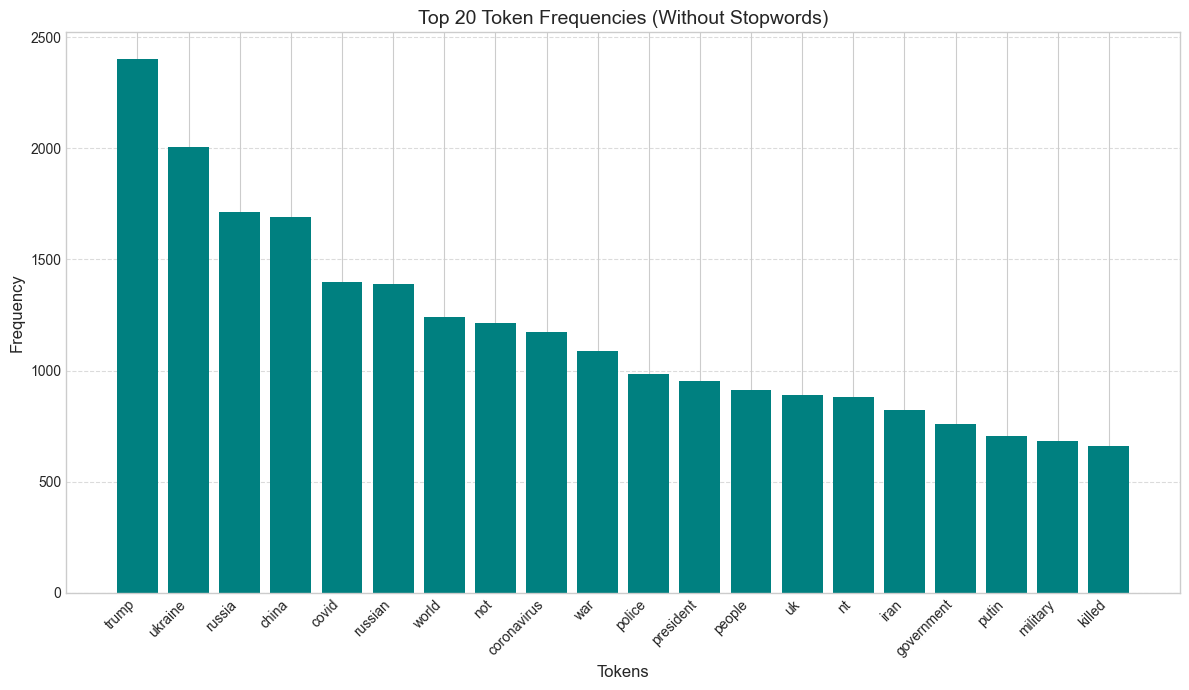

In [7]:


from collections import Counter
import matplotlib.pyplot as plt # Import for plotting
import pandas as pd # Assuming news_df is a pandas DataFrame


print("\n--- TOKEN ANALYSIS ---")

# Calculate counts from the combined list of tokens
# Assuming 'tokens' represents the concatenated tokens for a row
token_count_before = sum(news_df['tokens'].apply(len))
token_count_after = sum(news_df['tokens_nostop'].apply(len))

print("Original total token count:", token_count_before)
print("Total token count after stopword removal:", token_count_after)
print("Reduction: {:.2f}%".format((1 - token_count_after / token_count_before) * 100))

# Display sample for tokens (from the combined list)
print("\nSample before stopword removal (first 20 tokens in the first row):")
# Handle potential empty lists gracefully
print(news_df['tokens'].iloc[0][:20] if news_df['tokens'].iloc[0] else "[]")
print("\nSample after stopword removal (first 20 tokens in the first row):")
# Handle potential empty lists gracefully
print(news_df['tokens_nostop'].iloc[0][:20] if news_df['tokens_nostop'].iloc[0] else "[]")


# Flatten the list of lists of tokens after stopword removal across the entire DataFrame
# This collects *all* non-stopword tokens into a single list for frequency counting
all_tokens_nostop = [token for tokens_list in news_df['tokens_nostop'].tolist() for token in tokens_list]

# Calculate frequency distribution
token_freq = Counter(all_tokens_nostop)

# Print Top N tokens
N = 20
print(f"\n--- TOP {N} TOKENS WITHOUT STOPWORDS ---")
top_tokens = token_freq.most_common(N)
print(top_tokens)

# --- VISUALIZATION ---
print(f"\n--- PLOTTING TOP {N} TOKENS ---")

if top_tokens:
    # Prepare data for plotting
    tokens, counts = zip(*top_tokens)

    plt.figure(figsize=(12, 7)) # Adjust figure size for better readability
    plt.bar(tokens, counts, color='teal') # Using a different color
    plt.xlabel('Tokens', fontsize=12) # Increase font size for labels
    plt.ylabel('Frequency', fontsize=12)
    plt.title(f'Top {N} Token Frequencies (Without Stopwords)', fontsize=14) # Increase font size for title
    plt.xticks(rotation=45, ha='right', fontsize=10) # Rotate and adjust alignment of labels
    plt.yticks(fontsize=10) # Increase font size for y-axis ticks
    plt.grid(axis='y', linestyle='--', alpha=0.7) # Add a grid for better readability
    plt.tight_layout() # Adjust layout to prevent labels overlapping
    plt.show()
else:
    print("No tokens found to plot.")

# **Part of Speech Tagging And Lemmatization** 
 Now that we have clean, unified tokens, we can perform Part-of-Speech (POS) tagging. 

 POS tagging assigns a grammatical category (like noun, verb, adjective) to each token.
 
 This is crucial for understanding sentence structure and meaning.

 We will be POS tagging and lemmatizing in the same cell, because:




Lemmatization reduces words to their base form (lemma), like running -> run. We will do this to keep track of trends and sentiment in a more robust way. <br>
You might be questioning why we are taking the input of normalized tokens instead of just using the POS tagged column of our dataframe that we will be creating, <br> 
this is because POS tagged column is made out of a list of list of tuples, while lemmatization requires the input of lists that contain single token strings. <br>
The workaround is using POS tagging and lemmatization in a single passtrough of our normalized tokens list, and creating 4 new columns in total, <br>
of new POS tagged combined and separate, and lemmatized combined and separate. 

Lemmatization uses POS tagging as context to strip down them, so POS tagging data is crucial for accurate lemmatization, and for the other reasons explained above, they are in a single cell. 

In [8]:
import spacy
from itertools import compress
from collections import defaultdict
from tqdm import tqdm
import warnings


# Load spaCy model with lemmatizer enabled, but still disable parser and NER for speed
nlp = spacy.load("en_core_web_md", disable=["parser", "ner", "senter"])

# Define a function to safely join tokens
def safe_join(tokens):

    if not tokens:
        return ""
    try:
        return " ".join(str(tok) for tok in tokens)
    except Exception as e:
        print(f"Error joining tokens: {e}")
        return ""

# Function to safely process a batch with retry for errors
def process_batch_with_retry(texts, batch_size=512, n_process=None):
    results = []
    errors = []
    
    # Use the recommended way to determine processes
    if n_process is None:
        # Let spaCy decide based on available cores
        n_process = -1
    
    # Process texts with tqdm for progress tracking
    with tqdm(total=len(texts), desc="Processing texts") as pbar:
        # Safely process with retries on errors
        try:
            # Process texts in batches
            for i, doc in enumerate(nlp.pipe(texts, batch_size=batch_size, n_process=n_process)):
                try:
                    # Extract text, POS tag, and lemma for each token
                    results.append([(tok.text, tok.pos_, tok.lemma_) for tok in doc])
                    pbar.update(1)
                except Exception as e:
                    print(f"Error processing text at index {i}: {e}")
                    errors.append(i)
                    results.append([])  # Add empty result to maintain index alignment
                    pbar.update(1)
        except Exception as e:
            print(f"Batch processing error: {e}")
            # Fall back to sequential processing for remaining texts
            if errors:
                print(f"Retrying {len(errors)} failed texts sequentially...")
                for i in errors:
                    try:
                        if i < len(texts):
                            doc = nlp(texts[i])
                            results[i] = [(tok.text, tok.pos_, tok.lemma_) for tok in doc]
                    except Exception as e2:
                        print(f"Sequential retry failed for text at index {i}: {e2}")
    
    return results

# ------------------------------------------------
# 1)  COMBINED-HEADLINE LEMMATIZATION
# ------------------------------------------------
print("Lemmatizing and POS tagging – combined headlines...")

# Check if required column exists
if 'tokens_normalized' not in news_df.columns:
    print("Warning: 'tokens_normalized' column not found. Please run token normalization first.")
else:
    # Build list of texts and remember their DataFrame indices
    texts_combined = [safe_join(toks) for toks in news_df['tokens_normalized']]
    non_empty_mask = [bool(txt.strip()) for txt in texts_combined]
    texts_non_empty = list(compress(texts_combined, non_empty_mask))
    idx_mapping = [i for i, keep in enumerate(non_empty_mask) if keep]
    
    # Show stats
    print(f"Processing {len(texts_non_empty):,} non-empty texts out of {len(texts_combined):,} total")
    
    # Handle edge case of no texts
    if not texts_non_empty:
        warnings.warn("No non-empty texts found for lemmatization!")
        lemma_pos_combined = [[] for _ in range(len(news_df))]
    else:
        # Prepare result container (same length as DataFrame)
        lemma_pos_combined = [[] for _ in range(len(news_df))]
        
        # Determine optimal batch size based on text length
        avg_len = sum(len(t) for t in texts_non_empty) / max(1, len(texts_non_empty))
        batch_size = max(32, min(512, int(10000 / max(1, avg_len))))
        print(f"Using batch size of {batch_size} based on average text length of {avg_len:.1f} chars")
        
        # Determine optimal number of processes
        import os
        suggested_processes = min(4, os.cpu_count() or 1)
        print(f"Using {suggested_processes} processes for parallel processing")
        
        # Run spaCy in batches / multi-process
        lemma_results = process_batch_with_retry(
            texts_non_empty, 
            batch_size=batch_size, 
            n_process=suggested_processes
        )
        
        # Map results back to DataFrame positions
        for i, df_idx in enumerate(idx_mapping):
            if i < len(lemma_results):
                lemma_pos_combined[df_idx] = lemma_results[i]
    
    # Add to DataFrame
    news_df['lemma_pos_combined'] = lemma_pos_combined
    
    # Create a column with just the lemmatized tokens for convenience
    news_df['lemmas_combined'] = [
        [item[2] for item in token_list] if token_list else [] 
        for token_list in news_df['lemma_pos_combined']
    ]
    
    # Quick stats
    total_lemmas = sum(len(lemmas) for lemmas in news_df['lemmas_combined'])
    print(f"Total lemmas generated: {total_lemmas:,}")

# ------------------------------------------------
# 2)  SEPARATE-HEADLINE LEMMATIZATION
# ------------------------------------------------
print("\nLemmatizing and POS tagging – separate headlines...")

# Check if required column exists
if 'separate_tokens_normalized' not in news_df.columns:
    print("Warning: 'separate_tokens_normalized' column not found. Please run token normalization first.")
else:
    texts_sep = []   # flattened texts to send to spaCy
    row_map = []     # DataFrame row index for each text
    sub_map = []     # sub-list position inside that row
    
    # Handle potential iteritems vs items method difference (pandas version compatibility)
    iter_method = getattr(news_df['separate_tokens_normalized'], 'items', None)
    if iter_method is None:
        iter_method = news_df['separate_tokens_normalized'].iteritems
    
    # Collect texts with their mapping information
    for row_idx, headline_lists in iter_method():
        if not headline_lists:
            continue
            
        for sub_idx, toks in enumerate(headline_lists):
            if toks:  # already filtered empties
                text = safe_join(toks)
                if text.strip():  # Make sure we have actual content
                    texts_sep.append(text)
                    row_map.append(row_idx)
                    sub_map.append(sub_idx)
    
    # Show stats
    print(f"Processing {len(texts_sep):,} separate headlines")
    
    # Handle edge case of no texts
    if not texts_sep:
        warnings.warn("No non-empty separate headlines found for lemmatization!")
        news_df['lemma_pos_separate'] = [[] for _ in range(len(news_df))]
        news_df['lemmas_separate'] = [[] for _ in range(len(news_df))]
    else:
        # Determine optimal batch size based on text length
        avg_len = sum(len(t) for t in texts_sep) / max(1, len(texts_sep))
        batch_size = max(32, min(512, int(10000 / max(1, avg_len))))
        print(f"Using batch size of {batch_size} based on average text length of {avg_len:.1f} chars")
        
        # Determine optimal number of processes
        import os
        suggested_processes = min(4, os.cpu_count() or 1)
        print(f"Using {suggested_processes} processes for parallel processing")
        
        # Lemmatize and POS-tag all in one go with progress display
        docs_lemma = process_batch_with_retry(
            texts_sep, 
            batch_size=batch_size, 
            n_process=suggested_processes
        )
        
        # Re-assemble back into the original nested structure
        lemma_dict = defaultdict(list)   # row_idx -> list of lists
        
        for i, (row_idx, sub_idx) in enumerate(zip(row_map, sub_map)):
            if i >= len(docs_lemma):
                continue
                
            lemma_pos = docs_lemma[i]
            
            # ensure outer list long enough
            while len(lemma_dict[row_idx]) <= sub_idx:
                lemma_dict[row_idx].append([])
            
            lemma_dict[row_idx][sub_idx] = lemma_pos
        
        # Add to DataFrame
        news_df['lemma_pos_separate'] = news_df.index.map(lambda i: lemma_dict.get(i, []))
        
        # Create a nested list with just the lemmas for convenience
        news_df['lemmas_separate'] = news_df['lemma_pos_separate'].apply(
            lambda headline_lists: [
                [item[2] for item in tokens] if tokens else []
                for tokens in headline_lists
            ] if headline_lists else []
        )
        
        # Quick stats
        total_headlines = sum(len(lemmas) for lemmas in news_df['lemmas_separate'])
        total_lemmas = sum(len(headline) for headlines in news_df['lemmas_separate'] for headline in headlines)
        print(f"Total headlines processed: {total_headlines:,}")
        print(f"Total lemmas generated: {total_lemmas:,}")

# Sample display
print("\nSample lemmatization results:")
if 'lemma_pos_combined' in news_df.columns and len(news_df) > 0:
    sample_lemmas = news_df['lemma_pos_combined'].iloc[0][:5]
    print(f"First 5 combined lemmas with POS: {sample_lemmas}")
    
    sample_just_lemmas = news_df['lemmas_combined'].iloc[0][:5]
    print(f"First 5 combined lemmas only: {sample_just_lemmas}")

if 'lemma_pos_separate' in news_df.columns and len(news_df) > 0:
    # Get first headline's lemmas from first row
    if news_df['lemma_pos_separate'].iloc[0] and news_df['lemma_pos_separate'].iloc[0][0]:
        sample_sep_lemmas = news_df['lemma_pos_separate'].iloc[0][0][:5]
        print(f"First 5 lemmas with POS from first separate headline: {sample_sep_lemmas}")
        
        sample_sep_just_lemmas = news_df['lemmas_separate'].iloc[0][0][:5] if news_df['lemmas_separate'].iloc[0] else []
        print(f"First 5 lemmas only from first separate headline: {sample_sep_just_lemmas}")

# Display information about the columns we've added
print("\nNew columns added to DataFrame:")
print("  - lemma_pos_combined: List of (token, POS, lemma) tuples for combined headlines")
print("  - lemmas_combined: List of just lemmas for combined headlines")
print("  - lemma_pos_separate: Nested lists of (token, POS, lemma) tuples for separate headlines")
print("  - lemmas_separate: Nested lists of just lemmas for separate headlines")

# Display a simple visualization of lemmatization effects
if 'tokens_normalized' in news_df.columns and 'lemmas_combined' in news_df.columns and len(news_df) > 0:
    print("\nLemmatization example (first row):")
    tokens = news_df['tokens_normalized'].iloc[0][:10]  # First 10 tokens
    lemmas = news_df['lemmas_combined'].iloc[0][:10]    # First 10 lemmas
    
    if tokens and lemmas:
        print("Original tokens vs. Lemmas:")
        for i, (token, lemma) in enumerate(zip(tokens[:10], lemmas[:10])):
            if token != lemma:
                print(f"  {token} → {lemma}")

Lemmatizing and POS tagging – combined headlines...
Processing 1,771 non-empty texts out of 1,771 total
Using batch size of 32 based on average text length of 1612.1 chars
Using 4 processes for parallel processing


Processing texts: 100%|██████████| 1771/1771 [00:23<00:00, 75.24it/s] 


Total lemmas generated: 382,295

Lemmatizing and POS tagging – separate headlines...
Processing 44,073 separate headlines
Using batch size of 156 based on average text length of 63.8 chars
Using 4 processes for parallel processing


Processing texts: 100%|██████████| 44073/44073 [00:29<00:00, 1516.06it/s]


Total headlines processed: 44,073
Total lemmas generated: 382,020

Sample lemmatization results:
First 5 combined lemmas with POS: [('north', 'PROPN', 'north'), ('korea', 'PROPN', 'korea'), ('open', 'ADJ', 'open'), ('sky', 'NOUN', 'sky'), ('south', 'ADJ', 'south')]
First 5 combined lemmas only: ['north', 'korea', 'open', 'sky', 'south']
First 5 lemmas with POS from first separate headline: [('north', 'PROPN', 'north'), ('korea', 'PROPN', 'korea'), ('open', 'ADJ', 'open'), ('sky', 'NOUN', 'sky'), ('south', 'ADJ', 'south')]
First 5 lemmas only from first separate headline: ['north', 'korea', 'open', 'sky', 'south']

New columns added to DataFrame:
  - lemma_pos_combined: List of (token, POS, lemma) tuples for combined headlines
  - lemmas_combined: List of just lemmas for combined headlines
  - lemma_pos_separate: Nested lists of (token, POS, lemma) tuples for separate headlines
  - lemmas_separate: Nested lists of just lemmas for separate headlines

Lemmatization example (first row):
Or

# Part Of Speech Data Visualization

Lets see what we can learn from all the data we processed so far! We have a lot of data to process. We can start by graphing the POS tagging data, and inspect their various aspects.

Generating fixed visualizations for POS tagging data...
Analyzing POS tag distributions...
Debugging data structure:

Column: lemma_pos_combined
Sample row 0: <class 'list'>
  First tuple: <class 'tuple'>
  Sample tuples: [('north', 'PROPN', 'north'), ('korea', 'PROPN', 'korea'), ('open', 'ADJ', 'open')]

Column: lemma_pos_separate
Sample row 0: <class 'list'>
  First nested list: <class 'list'>
    First element in nested list: <class 'tuple'>
    First few items: [('north', 'PROPN', 'north'), ('korea', 'PROPN', 'korea'), ('open', 'ADJ', 'open')]

POS counts for lemma_pos_combined:
Total unique POS tags found: 17
Top 5 POS tags: [('NOUN', 146895), ('PROPN', 106574), ('VERB', 73346), ('ADJ', 41006), ('ADV', 5697)]

POS counts for lemma_pos_separate:
Total unique POS tags found: 17
Top 5 POS tags: [('NOUN', 153215), ('PROPN', 99389), ('VERB', 73641), ('ADJ', 41165), ('ADV', 5842)]


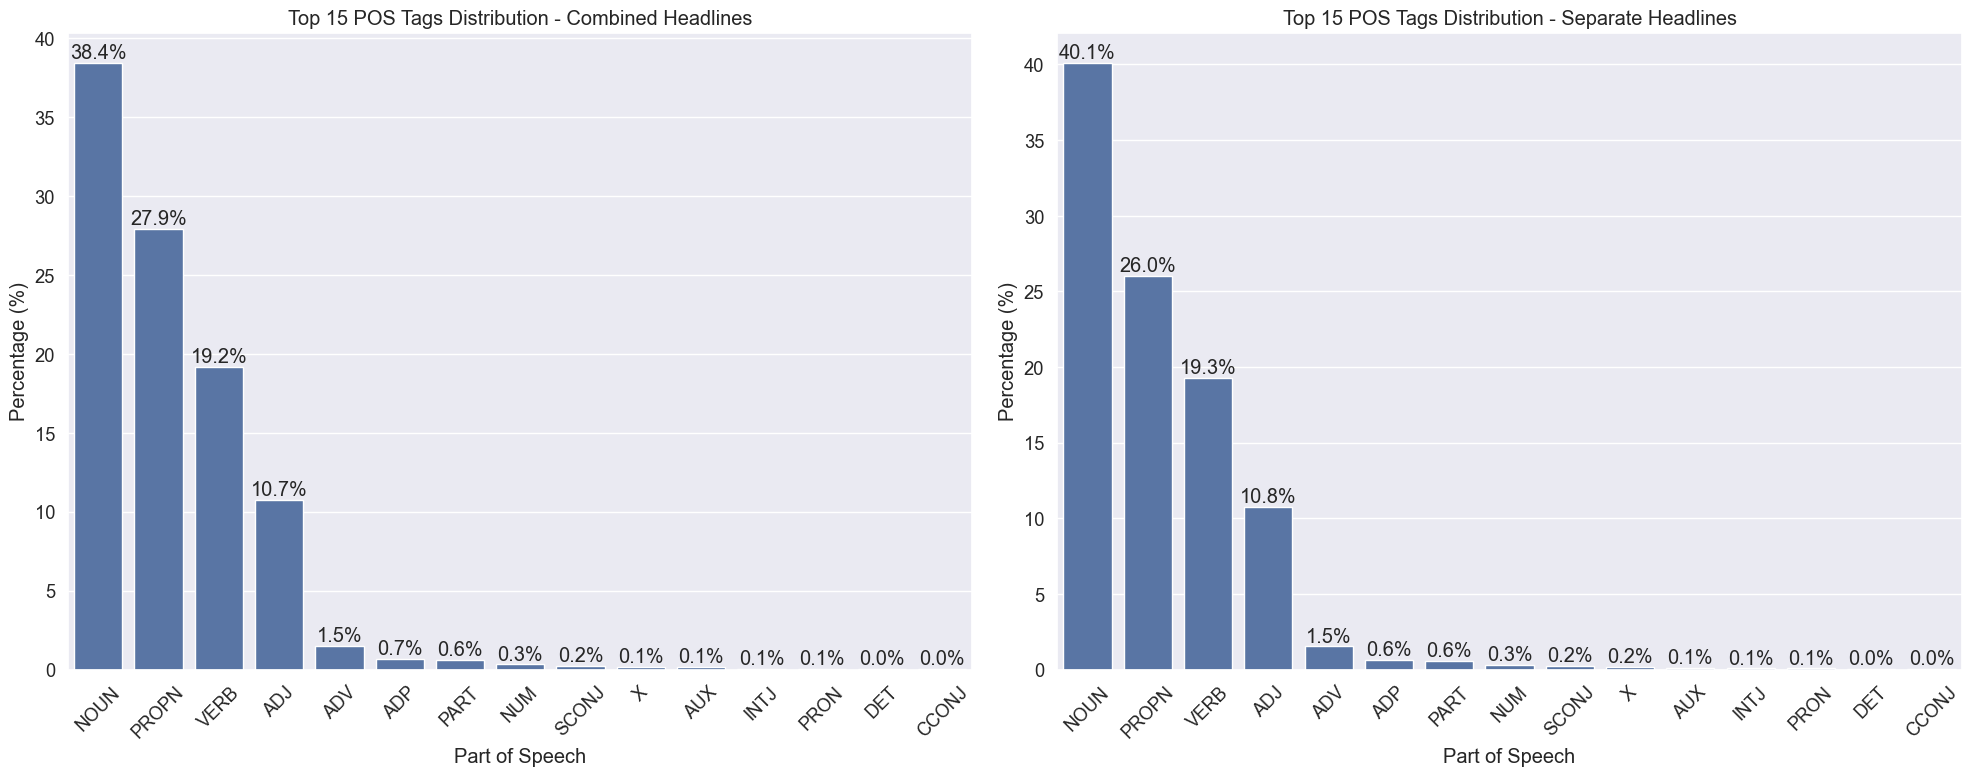

In [9]:
# ===========================
# POS TAGGING VISUALIZATION
# ===========================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
import re
from wordcloud import WordCloud
from matplotlib.ticker import PercentFormatter

print("Generating fixed visualizations for POS tagging data...")

# Set plot style
plt.style.use('ggplot')
sns.set(font_scale=1.2)

# --------------------------------
# 1) Distribution of POS Tags
# --------------------------------
print("Analyzing POS tag distributions...")

# Fixed function to count POS tags with better handling of nested structures
def count_tags(tags_column):
    tag_counts = Counter()
    
    # Skip empty DataFrames
    if len(tags_column) == 0:
        return tag_counts
        
    # Try to get a non-empty sample to determine the data structure
    sample = None
    for item in tags_column:
        if item:  # Find first non-empty item
            sample = item
            break
    
    if sample is None:
        return tag_counts
    
    # Handle different formats based on nesting level and tuple structure
    if isinstance(sample, list):
        # Check if it's the separate headlines format (list of lists of tuples)
        if sample and isinstance(sample[0], list):
            for headlines in tags_column:
                if not headlines:
                    continue
                for headline in headlines:
                    if not headline:
                        continue
                    # Check tuple format - (text, pos, lemma) or (text, pos)
                    if headline and isinstance(headline[0], tuple):
                        if len(headline[0]) == 3:  # New format (text, pos, lemma)
                            for _, pos, _ in headline:
                                tag_counts[pos] += 1
                        else:  # Old format (text, pos)
                            for _, pos in headline:
                                tag_counts[pos] += 1
        # It's the combined headlines format (list of tuples)
        elif sample and isinstance(sample[0], tuple):
            for tags in tags_column:
                if not tags:
                    continue
                # Check tuple format
                if len(tags[0]) == 3:  # New format (text, pos, lemma)
                    for _, pos, _ in tags:
                        tag_counts[pos] += 1
                else:  # Old format (text, pos)
                    for _, pos in tags:
                        tag_counts[pos] += 1
    
    return tag_counts

# Determine which columns to use for visualization
pos_columns = []
if 'lemma_pos_combined' in news_df.columns:
    pos_columns.append(('lemma_pos_combined', 'Combined Headlines'))
elif 'pos_tags_combined' in news_df.columns:
    pos_columns.append(('pos_tags_combined', 'Combined Headlines'))

if 'lemma_pos_separate' in news_df.columns:
    pos_columns.append(('lemma_pos_separate', 'Separate Headlines'))
elif 'pos_tags_separate' in news_df.columns:
    pos_columns.append(('pos_tags_separate', 'Separate Headlines'))

# Debug - print sample row data to verify structure
print("Debugging data structure:")
for col_name, title in pos_columns:
    print(f"\nColumn: {col_name}")
    # Find first non-empty row
    for i, row in enumerate(news_df[col_name]):
        if row:
            print(f"Sample row {i}: {type(row)}")
            if isinstance(row, list):
                if row and isinstance(row[0], list):
                    print(f"  First nested list: {type(row[0])}")
                    if row[0]:
                        print(f"    First element in nested list: {type(row[0][0])}")
                        print(f"    First few items: {row[0][:3]}")
                elif row and isinstance(row[0], tuple):
                    print(f"  First tuple: {type(row[0])}")
                    print(f"  Sample tuples: {row[:3]}")
            break

# Create separate figures based on available columns
num_plots = len(pos_columns)
if num_plots > 0:
    fig, axes = plt.subplots(1, num_plots, figsize=(10*num_plots, 8))
    # Handle single plot case
    if num_plots == 1:
        axes = [axes]
    
    for i, (col_name, title_suffix) in enumerate(pos_columns):
        # Count POS tags with the fixed function
        pos_counts = count_tags(news_df[col_name])
        
        # Debug to verify tag counting is working
        print(f"\nPOS counts for {col_name}:")
        print(f"Total unique POS tags found: {len(pos_counts)}")
        if pos_counts:
            top_5 = sorted(pos_counts.items(), key=lambda x: x[1], reverse=True)[:5]
            print(f"Top 5 POS tags: {top_5}")
        else:
            print("No POS tags found!")
        
        if not pos_counts:
            axes[i].text(0.5, 0.5, f"No POS tags found in {title_suffix}",
                         ha='center', va='center', fontsize=12)
            axes[i].set_title(f'POS Tags Distribution - {title_suffix}')
            axes[i].axis('off')
            continue
        
        pos_df = pd.DataFrame({
            'POS': list(pos_counts.keys()),
            'Count': list(pos_counts.values())
        }).sort_values('Count', ascending=False)
        
        # Calculate percentage
        total = pos_df['Count'].sum()
        pos_df['Percentage'] = pos_df['Count'] / total * 100
        
        # Plot top N tags
        top_n = min(15, len(pos_df))
        sns.barplot(x='POS', y='Percentage', data=pos_df.head(top_n), ax=axes[i])
        axes[i].set_title(f'Top {top_n} POS Tags Distribution - {title_suffix}')
        axes[i].set_ylabel('Percentage (%)')
        axes[i].set_xlabel('Part of Speech')
        axes[i].tick_params(axis='x', rotation=45)
        
        # Add value labels
        for j, p in enumerate(axes[i].patches):
            height = p.get_height()
            axes[i].text(p.get_x() + p.get_width()/2., height + 0.3,
                    f'{height:.1f}%', ha="center")
    
    plt.tight_layout()
    plt.savefig('pos_tag_distribution_fixed.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No POS tagging columns found in the DataFrame.")
    


# Tag Distribution

We can see that around 66% of headlines are made of nouns (proper nouns and common nouns combined.). Data representing numbers and such cannot be trusted as we are stripping them in our normalization. 

Nouns are followed by verbs and adjectives.

!!! 66/20 verb noun ratio is higher than what we see in literary context by an order of 4 to 5, according to 'Academia L1 English Verb to Noun Ratio' results.

---



#  Word Clouds by POS Tag



Generating word clouds for common POS tags...


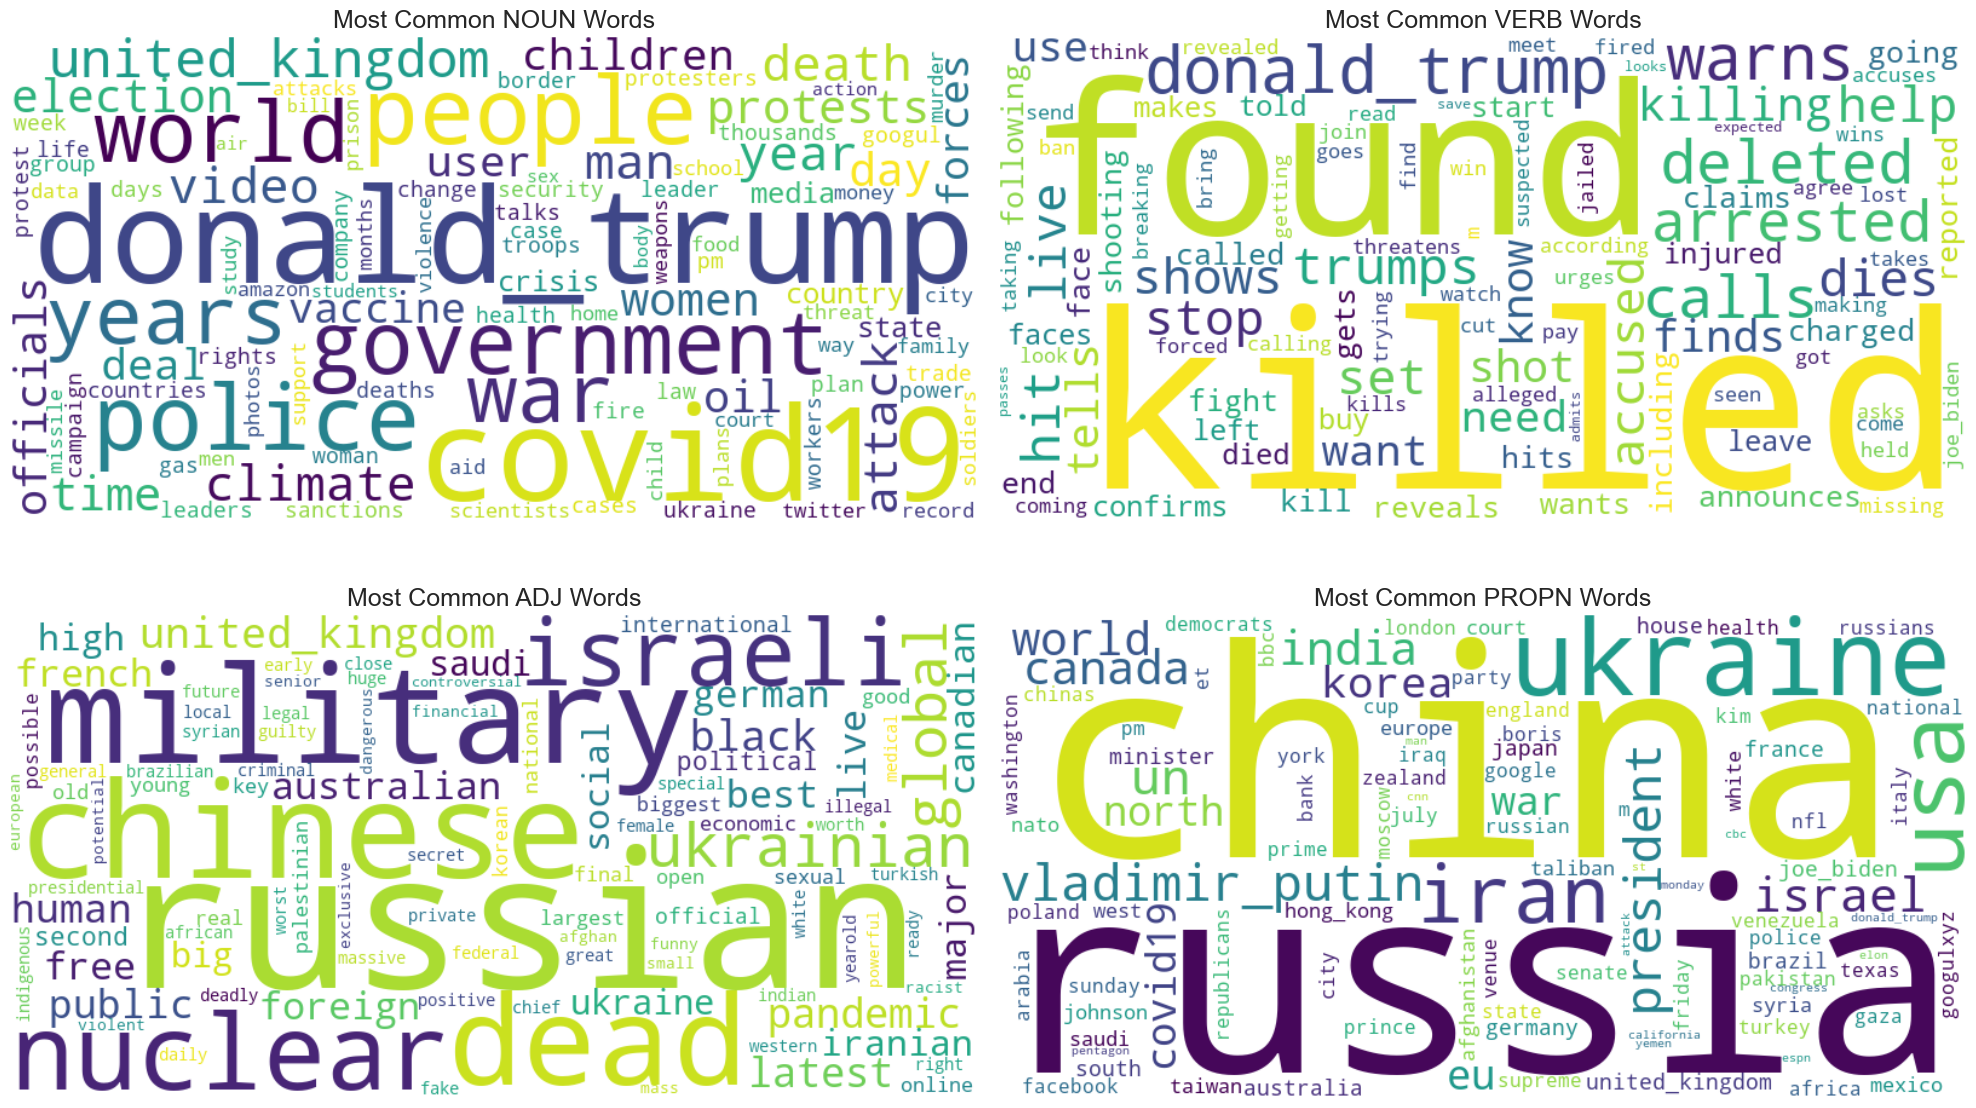

In [10]:

print("Generating word clouds for common POS tags...")

# Function to extract words by POS tag with support for new format
def get_words_by_pos(tags_column, target_pos):
    words = []
    
    # Skip empty DataFrames
    if len(tags_column) == 0:
        return words
        
    # Check the format of the data
    sample = next((x for x in tags_column if x), None)
    
    if sample is None:
        return words
        
    # Handle different formats
    if isinstance(sample, list):
        if not sample:
            return words
            
        if isinstance(sample[0], tuple):
            # Check if it's the new format with (text, pos, lemma) or old format with (text, pos)
            if len(sample[0]) == 3:  # New format with lemma
                for tags in tags_column:
                    words.extend([word.lower() for word, pos, _ in tags if pos == target_pos])
            else:  # Old format
                for tags in tags_column:
                    words.extend([word.lower() for word, pos in tags if pos == target_pos])
    else:
        # Handle nested lists (separate headlines)
        for headlines in tags_column:
            if not headlines:
                continue
                
            for headline in headlines:
                if not headline:
                    continue
                    
                # Check if it's the new format
                if len(headline[0]) == 3:  # New format with lemma
                    words.extend([word.lower() for word, pos, _ in headline if pos == target_pos])
                else:  # Old format
                    words.extend([word.lower() for word, pos in headline if pos == target_pos])
    
    return words

# Select important POS categories to visualize
important_pos = ['NOUN', 'VERB', 'ADJ', 'PROPN']

# Choose which column to use for word clouds (prioritize lemma_pos_combined)
wordcloud_col = None
if 'lemma_pos_combined' in news_df.columns:
    wordcloud_col = 'lemma_pos_combined'
elif 'pos_tags_combined' in news_df.columns:
    wordcloud_col = 'pos_tags_combined'
elif 'lemma_pos_separate' in news_df.columns:
    wordcloud_col = 'lemma_pos_separate'
elif 'pos_tags_separate' in news_df.columns:
    wordcloud_col = 'pos_tags_separate'

if wordcloud_col:
    # Create word clouds for important POS tags
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    axes = axes.flatten()
    
    # Use the selected column for word clouds
    for i, pos in enumerate(important_pos):
        words = get_words_by_pos(news_df[wordcloud_col], pos)
        word_counts = Counter(words)
        
        # Skip if no words found
        if not word_counts:
            axes[i].text(0.5, 0.5, f"No {pos} tags found", 
                         horizontalalignment='center', fontsize=18)
            axes[i].axis('off')
            continue
        
        # Generate word cloud
        wc = WordCloud(width=800, height=400, 
                       background_color='white', 
                       max_words=100,
                       colormap='viridis',
                       contour_width=1, contour_color='steelblue')
        
        wc.generate_from_frequencies(word_counts)
        
        axes[i].imshow(wc, interpolation='bilinear')
        axes[i].set_title(f'Most Common {pos} Words', fontsize=18)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0)  # Try smaller values like 0.1 or 0.05 if needed
    plt.savefig('pos_word_clouds.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No suitable columns found for word cloud visualization.")

    


 ## Word Cloud Representation
 
 Covid is NOT the most talked about topic even though it felt like that living through that era, it was actually Donald Trump. More info about this later!

 Russia, China and Ukraine was the 3 countries that news outlets talked the most about

 ---



# Headline POS Tag Sequence Patterns



Analyzing common POS tag sequences...


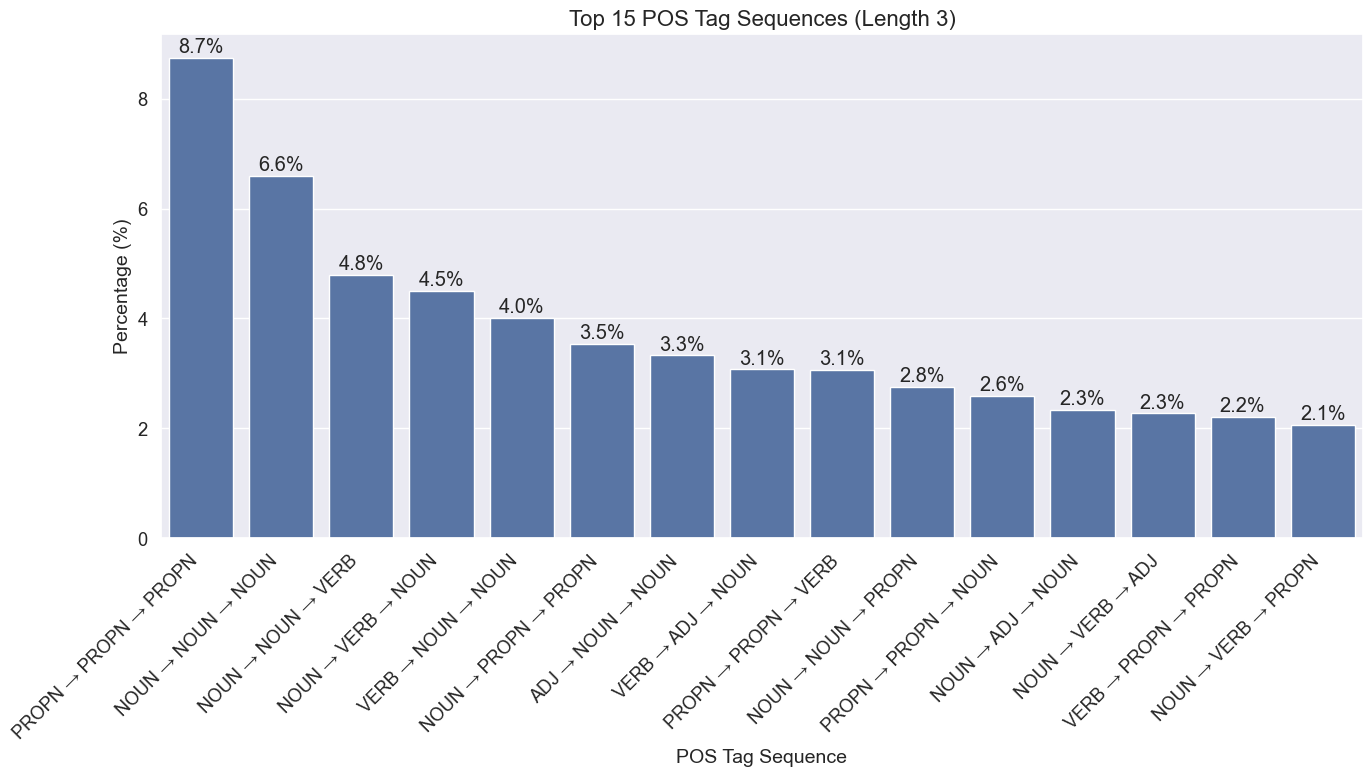

In [11]:

print("Analyzing common POS tag sequences...")

# Function to extract common POS sequences with support for new format
def get_pos_sequences(tags_column, seq_length=3):
    sequences = []
    
    # Skip empty DataFrames
    if len(tags_column) == 0:
        return sequences
        
    # Check the format of the data
    sample = next((x for x in tags_column if x), None)
    
    if sample is None:
        return sequences
        
    # Handle different formats
    if isinstance(sample, list):
        if not sample:
            return sequences
            
        if isinstance(sample[0], tuple):
            # Check if it's the new format with (text, pos, lemma) or old format with (text, pos)
            if len(sample[0]) == 3:  # New format with lemma
                for tags in tags_column:
                    if len(tags) >= seq_length:
                        pos_tags = [pos for _, pos, _ in tags]
                        for i in range(len(pos_tags) - seq_length + 1):
                            sequences.append(tuple(pos_tags[i:i+seq_length]))
            else:  # Old format
                for tags in tags_column:
                    if len(tags) >= seq_length:
                        pos_tags = [pos for _, pos in tags]
                        for i in range(len(pos_tags) - seq_length + 1):
                            sequences.append(tuple(pos_tags[i:i+seq_length]))
    else:
        # Handle nested lists (separate headlines)
        for headlines in tags_column:
            if not headlines:
                continue
                
            for headline in headlines:
                if len(headline) >= seq_length:
                    # Check if it's the new format
                    if len(headline[0]) == 3:  # New format with lemma
                        pos_tags = [pos for _, pos, _ in headline]
                        for i in range(len(pos_tags) - seq_length + 1):
                            sequences.append(tuple(pos_tags[i:i+seq_length]))
                    else:  # Old format
                        pos_tags = [pos for _, pos in headline]
                        for i in range(len(pos_tags) - seq_length + 1):
                            sequences.append(tuple(pos_tags[i:i+seq_length]))
    
    return sequences

# Choose which column to use for sequence analysis (prioritize lemma_pos_combined)
sequence_col = None
if 'lemma_pos_combined' in news_df.columns:
    sequence_col = 'lemma_pos_combined'
elif 'pos_tags_combined' in news_df.columns:
    sequence_col = 'pos_tags_combined'
elif 'lemma_pos_separate' in news_df.columns:
    sequence_col = 'lemma_pos_separate'
elif 'pos_tags_separate' in news_df.columns:
    sequence_col = 'pos_tags_separate'

if sequence_col:
    seq_length = 3  # trigrams
    sequences = get_pos_sequences(news_df[sequence_col], seq_length)
    seq_counts = Counter(sequences)
    
    # Create DataFrame for top sequences
    top_n = 15
    seq_df = pd.DataFrame({
        'Sequence': [' → '.join(seq) for seq in seq_counts.keys()],
        'Count': list(seq_counts.values())
    }).sort_values('Count', ascending=False).head(top_n)
    
    # Calculate percentage
    total = sum(seq_counts.values())
    seq_df['Percentage'] = seq_df['Count'] / total * 100
    
    # Plot top sequences
    plt.figure(figsize=(14, 8))
    bars = sns.barplot(x='Sequence', y='Percentage', data=seq_df)
    plt.title(f'Top {top_n} POS Tag Sequences (Length {seq_length})', fontsize=16)
    plt.xlabel('POS Tag Sequence', fontsize=14)
    plt.ylabel('Percentage (%)', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    
    # Add value labels
    for i, p in enumerate(bars.patches):
        height = p.get_height()
        plt.text(p.get_x() + p.get_width()/2., height + 0.1,
                f'{height:.1f}%', ha="center")
    
    plt.tight_layout()
    plt.savefig('pos_sequence_patterns.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No suitable columns found for sequence pattern analysis.")

    


 ## POS Sequence Results
 
 24.3% of 3 word sequences are made out of either proper nouns or common nouns,

 22.1% of 3 words sequences include a verb.
 
 *I wonder if this will have serious implications with the future graphs?..*

Analyzing headline length percentages...

Percentage of Headline Lengths (1–13 Words) for Separate Headlines:

 1 words:  0.60%    12 words:  3.09%
 2 words:  2.01%    13 words:  1.92%
 3 words:  1.97%    14 words:  1.20%
 4 words:  4.05%    15 words:  1.04%
 5 words:  7.99%    16 words:  0.86%
 6 words: 13.43%    17 words:  0.74%
 7 words: 17.63%    18 words:  0.70%
 8 words: 16.60%    19 words:  0.65%
 9 words: 12.24%    20 words:  0.55%
10 words:  8.03%    21 words:  0.00%


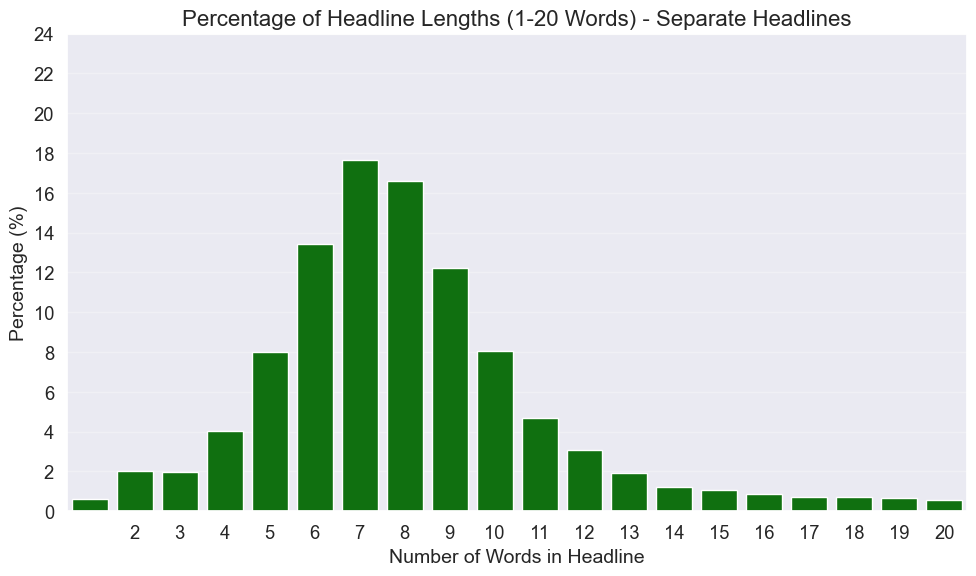

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("Analyzing headline length percentages...")

# Function to get POS tag counts per headline
def get_pos_counts_per_headline(tags_column):
    counts = []
    if tags_column.empty:
        return counts

    sample = tags_column.iloc[0]

    if all(isinstance(elem, tuple) for elem in sample):
        for tags in tags_column:
            counts.append(len(tags))
    else:
        for headlines in tags_column:
            if not headlines:
                continue
            for headline in headlines:
                counts.append(len(headline))
    return counts

# Choose the relevant column
length_columns = []
if 'lemma_pos_separate' in news_df.columns:
    length_columns.append(('lemma_pos_separate', 'Separate Headlines', 'green'))
elif 'pos_tags_separate' in news_df.columns:
    length_columns.append(('pos_tags_separate', 'Separate Headlines', 'green'))

if length_columns:
    for col_name, label, color in length_columns:
        counts = get_pos_counts_per_headline(news_df[col_name])
        filtered_counts = [c for c in counts if 1 <= c <= 20]
        total = len(filtered_counts)

        # Count occurrences and convert to percentages
        length_series = pd.Series(filtered_counts)
        length_percent = (length_series.value_counts(normalize=True) * 100).sort_index()
         # Print percentages in two columns (1–6 on left, 7–13 on right)
        print(f"\nPercentage of Headline Lengths (1–13 Words) for {label}:\n")
        left = list(range(1, 12))
        right = list(range(12, 22))

        for l, r in zip(left, right):
            l_val = length_percent.get(l, 0)
            r_val = length_percent.get(r, 0)
            print(f"{l:2d} words: {l_val:5.2f}%    {r:2d} words: {r_val:5.2f}%")

        # Plot
        plt.figure(figsize=(10, 6))
        sns.barplot(x=length_percent.index, y=length_percent.values, color=color)
        plt.title(f'Percentage of Headline Lengths (1-20 Words) - {label}', fontsize=16)
        plt.xlabel('Number of Words in Headline', fontsize=14)
        plt.ylabel('Percentage (%)', fontsize=14)
        plt.xticks(range(1, 20))
        plt.ylim(0, length_percent.max() + 5)
        plt.grid(True, axis='y', alpha=0.3)
        plt.yticks(range(0, 26, 2))
        plt.tight_layout()
        plt.savefig(f'headline_length_percent_{col_name}.png', dpi=300, bbox_inches='tight')
        plt.show()
else:
    print("No suitable columns found for headline length analysis.")


## Headline Length Results

59.86% of headlines are 6 to 9 words. There is a clear trend here, probably this is the **golden spot** that makes us click more. *Not too long to lose your attention, not too short to miss your attention.*




# 5) Comparative Analysis Between Different Headlines




Analyzing POS tag variations across headlines...


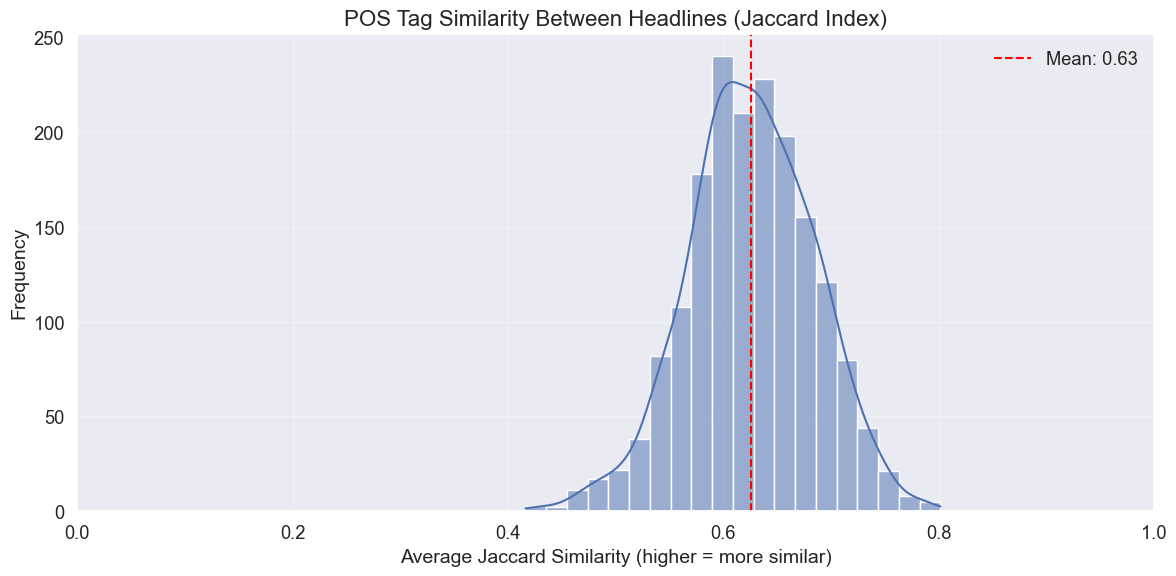

Visualization complete! All plots have been saved as PNG files.


In [13]:

print("Analyzing POS tag variations across headlines...")

# Choose which column to use for comparative analysis (prioritize lemma_pos_separate)
comparison_col = None
if 'lemma_pos_separate' in news_df.columns:
    comparison_col = 'lemma_pos_separate'
elif 'pos_tags_separate' in news_df.columns:
    comparison_col = 'pos_tags_separate'

if comparison_col:
    # Function to calculate POS tag diversity with support for new format
    def calculate_pos_diversity(headlines_tags):
        headline_diversities = []
        
        for headlines in headlines_tags:
            if len(headlines) >= 2:  # Need at least 2 headlines to compare
                # Calculate Jaccard similarity between headlines
                similarities = []
                for i in range(len(headlines)):
                    for j in range(i+1, len(headlines)):
                        # Check if it's the new format
                        if len(headlines[i][0]) == 3 and len(headlines[j][0]) == 3:  # New format with lemma
                            # Extract POS tags
                            pos_i = [pos for _, pos, _ in headlines[i]]
                            pos_j = [pos for _, pos, _ in headlines[j]]
                        else:  # Old format
                            # Extract POS tags
                            pos_i = [pos for _, pos in headlines[i]]
                            pos_j = [pos for _, pos in headlines[j]]
                        
                        # Calculate Jaccard similarity (intersection / union)
                        set_i = set(pos_i)
                        set_j = set(pos_j)
                        intersection = len(set_i.intersection(set_j))
                        union = len(set_i.union(set_j))
                        
                        if union > 0:
                            similarities.append(intersection / union)
                
                # Average similarity for this row
                if similarities:
                    headline_diversities.append(np.mean(similarities))
        
        return headline_diversities
    
    # Calculate diversity scores
    diversity_scores = calculate_pos_diversity(news_df[comparison_col])
    
    # Plot diversity distribution if we have enough data
    if diversity_scores:
        plt.figure(figsize=(12, 6))
        sns.histplot(diversity_scores, bins=20, kde=True)
        plt.title('POS Tag Similarity Between Headlines (Jaccard Index)', fontsize=16)
        plt.xlabel('Average Jaccard Similarity (higher = more similar)', fontsize=14)
        plt.ylabel('Frequency', fontsize=14)
        plt.xlim(0, 1)
        plt.axvline(np.mean(diversity_scores), color='red', linestyle='--', 
                    label=f'Mean: {np.mean(diversity_scores):.2f}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('headline_pos_similarity.png', dpi=300, bbox_inches='tight')
        plt.show()
    else:
        print("Not enough comparable headlines found for diversity analysis.")
else:
    print("No suitable columns found for comparative analysis.")

print("Visualization complete! All plots have been saved as PNG files.")

## Headline Similarity (Jaccard Index)

The finding that 63% of leading daily headlines adhere to a **comparable grammatical structure** indicates that <br>
the effectiveness of news conveyance extends beyond our acknowledgment of 6-9 word count. <br>
*Rather, it underscores the importance of a consistent approach in their utilization of various parts of speech.*



 TO DO:
 Most common verbs
 Most common Nouns
 Most common phrases of words



# Feature Extraction

## 1. Bag of Words (CountVectorizer)

**Bag of words** model is an orderless model that is focused on frequency, or the *number of ocurrences* for a given word. 

The number of occurence of a word (its frequency) is assigned to that word in a tuple, this data is then <br>
used by *Large Language Models* to guess the probability of the next word by calculating their comparative bigram frequency, <br>
or in other words, their statistical chance of appearing together according to its training data. 

Creating Bag of Words features...
Bag of Words: Created 5000 features from 1771 documents
Vocabulary size: 5000

Sample of BoW features (first 5 rows, first 5 features):
   aaron  abandon  abbas  abc  abduct
0      0        0      0    0       0
1      0        0      1    0       0
2      0        0      0    1       0
3      0        0      0    0       0
4      0        0      0    0       0
Top 20 most common words:
 [('donald_trump', np.int64(2724)), ('covid19', np.int64(2606)), ('ukraine', np.int64(2056)), ('russia', np.int64(1775)), ('china', np.int64(1750)), ('russian', np.int64(1395)), ('world', np.int64(1378)), ('united_kingdom', np.int64(1298)), ('kill', np.int64(1198)), ('year', np.int64(1164)), ('war', np.int64(1160)), ('usa', np.int64(1086)), ('attack', np.int64(1013)), ('police', np.int64(988)), ('people', np.int64(940)), ('protest', np.int64(909)), ('government', np.int64(903)), ('president', np.int64(876)), ('iran', np.int64(838)), ('man', np.int64(819))]


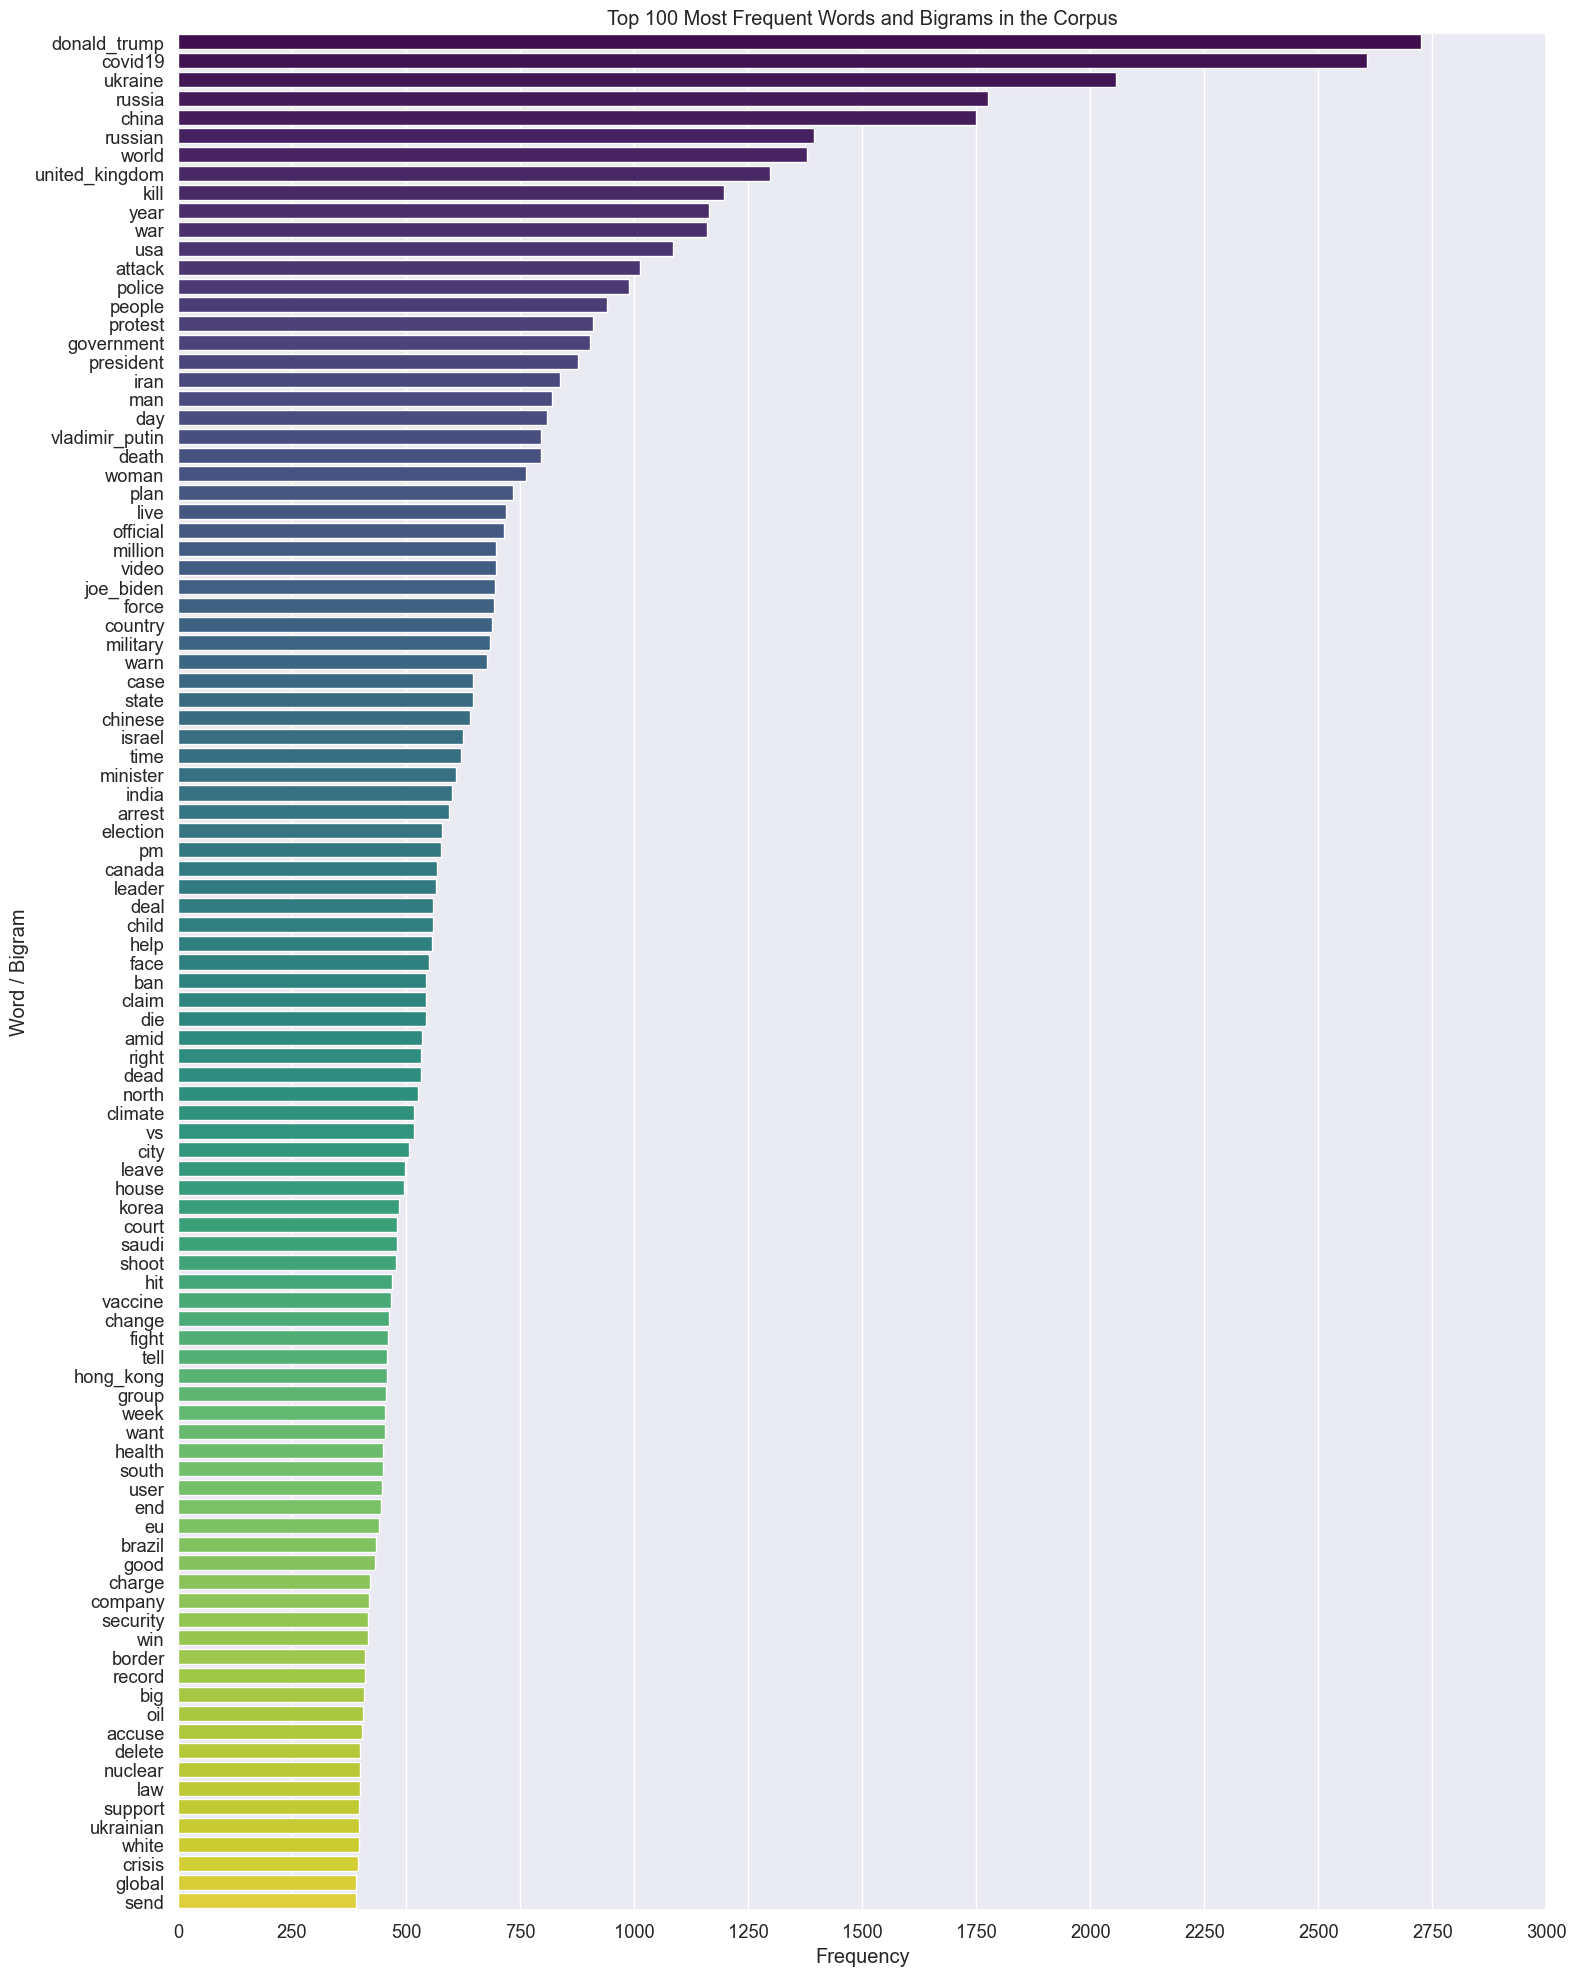

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("Creating Bag of Words features...")

# Function to convert token lists to space-separated strings
def tokens_to_string(token_list):
    if not token_list or len(token_list) == 0:
        return ""
    return " ".join(str(token) for token in token_list)

# Create corpus from lemmatized tokens
corpus = news_df['lemmas_combined'].apply(tokens_to_string)

# Initialize and fit the CountVectorizer
bow_vectorizer = CountVectorizer(
    min_df=2,          # Include words that appear in at least 2 documents
    max_df=0.9,        # Exclude very common words (appear in >90% of docs)
    max_features=5000, # Limit vocabulary size
    ngram_range=(1, 6),# Include unigrams and bigrams
    stop_words='english'  # Optional: filter out common English stopwords
)

# Create the BoW features
bow_features = bow_vectorizer.fit_transform(corpus)

# Get feature names (vocabulary)
bow_feature_names = bow_vectorizer.get_feature_names_out()

# Convert to DataFrame for easier viewing
bow_df = pd.DataFrame(
    bow_features.toarray(), 
    columns=bow_feature_names,
    index=news_df.index
)

# Display stats and sample
print(f"Bag of Words: Created {bow_features.shape[1]} features from {bow_features.shape[0]} documents")
print(f"Vocabulary size: {len(bow_feature_names)}")
print("\nSample of BoW features (first 5 rows, first 5 features):")
print(bow_df.iloc[:5, :5])

# Save the sparse matrix to news_df for later use
news_df['bow_features'] = pd.Series([bow_features[i] for i in range(bow_features.shape[0])])

# Analyze top N words
word_counts = np.asarray(bow_features.sum(axis=0)).flatten()
vocab_freq = list(zip(bow_feature_names, word_counts))
vocab_freq.sort(key=lambda x: x[1], reverse=True)
print("Top 20 most common words:\n", vocab_freq[:20])

# Visualize top N words
TOP_N = 100
top_words_df = pd.DataFrame(vocab_freq[:TOP_N], columns=['word', 'count'])

plt.figure(figsize=(16, 20))
sns.barplot(data=top_words_df, x='count', y='word', palette='viridis')
plt.title(f"Top {TOP_N} Most Frequent Words and Bigrams in the Corpus")
plt.xlabel("Frequency")
plt.xticks(range(0, 3001, 250))
plt.ylabel("Word / Bigram")
plt.tight_layout()
plt.savefig('mostfrequentwords.png', dpi=100, bbox_inches='tight')
plt.show()





## Cell 2: TF-IDF Features



In [15]:

from sklearn.feature_extraction.text import TfidfVectorizer

print("\nCreating TF-IDF features...")

# Initialize and fit the TF-IDF Vectorizer
# Using similar parameters as BoW for consistency
tfidf_vectorizer = TfidfVectorizer(
    min_df=5,
    max_df=0.5,
    max_features=5000,
    norm='l2',       # L2 normalization (default)
    use_idf=True,    # Enable IDF weighting
    smooth_idf=True  # Add 1 to document frequencies to avoid division by zero
)

# Create the TF-IDF features
tfidf_features = tfidf_vectorizer.fit_transform(corpus)

# Get feature names
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# Convert to DataFrame for easier viewing
tfidf_df = pd.DataFrame(
    tfidf_features.toarray(), 
    columns=tfidf_feature_names,
    index=news_df.index
)

# Display stats and sample
print(f"TF-IDF: Created {tfidf_features.shape[1]} features from {tfidf_features.shape[0]} documents")
print("\nSample of TF-IDF features (first 5 rows, first 10 features):")
print(tfidf_df.iloc[:5, :10])

# Find the most important terms in the first document as an example
if tfidf_features.shape[0] > 0:
    first_doc_tfidf = tfidf_features[0].toarray()[0]
    top_indices = np.argsort(first_doc_tfidf)[::-1][:10]  # Top 10 terms
    top_terms = [(tfidf_feature_names[i], first_doc_tfidf[i]) for i in top_indices if first_doc_tfidf[i] > 0]
    
    print("\nTop TF-IDF terms in first document:")
    for term, score in top_terms:
        print(f"  {term}: {score:.4f}")

# Save the sparse matrix to news_df for later use
news_df['tfidf_features'] = pd.Series([tfidf_features[i] for i in range(tfidf_features.shape[0])])





Creating TF-IDF features...
TF-IDF: Created 5000 features from 1771 documents

Sample of TF-IDF features (first 5 rows, first 10 features):
   aaron  abandon     abbas       abc  abduct  abe  ability  able  aboard  \
0    0.0      0.0  0.000000  0.000000     0.0  0.0      0.0   0.0     0.0   
1    0.0      0.0  0.092626  0.000000     0.0  0.0      0.0   0.0     0.0   
2    0.0      0.0  0.000000  0.069103     0.0  0.0      0.0   0.0     0.0   
3    0.0      0.0  0.000000  0.000000     0.0  0.0      0.0   0.0     0.0   
4    0.0      0.0  0.000000  0.000000     0.0  0.0      0.0   0.0     0.0   

   aboriginal  
0    0.000000  
1    0.000000  
2    0.000000  
3    0.095018  
4    0.000000  

Top TF-IDF terms in first document:
  hair: 0.3097
  treatment: 0.2014
  flynn: 0.2005
  mueller: 0.1997
  loose: 0.1909
  brand: 0.1445
  medical: 0.1293
  patient: 0.1267
  city: 0.1251
  effort: 0.1219




## Cell 3: Word Embeddings using spaCy's pre-trained vectors



In [16]:

import numpy as np
from tqdm import tqdm

print("\nCreating Word Embedding features...")

# We'll use the same spaCy model you already loaded for lemmatization
# This assumes 'nlp' from your original code is still accessible

# Function to get embedding for a single token
def get_token_vector(token):
    # Get the embedding if it exists, otherwise return zero vector
    if token in nlp.vocab:
        return nlp.vocab[token].vector
    return np.zeros(nlp.vocab.vectors.shape[1])

# Function to get document embedding by averaging token embeddings
def get_doc_embedding(tokens):
    if not tokens or len(tokens) == 0:
        return np.zeros(nlp.vocab.vectors.shape[1])
    
    # Get vectors for all tokens and average them
    vectors = [get_token_vector(token) for token in tokens]
    return np.mean(vectors, axis=0)

# Create embeddings for each document
print("Generating embeddings from lemmatized tokens...")
embeddings = []

# Use tqdm for progress tracking
for lemmas in tqdm(news_df['lemmas_combined'], desc="Creating embeddings"):
    embeddings.append(get_doc_embedding(lemmas))

# Convert to numpy array for easier manipulation
embeddings_array = np.vstack(embeddings)

# Create a DataFrame with the embeddings
# Use a prefix to name the columns
embedding_dim = embeddings_array.shape[1]
embedding_cols = [f'emb_{i}' for i in range(embedding_dim)]
embeddings_df = pd.DataFrame(
    embeddings_array,
    columns=embedding_cols,
    index=news_df.index
)

# Display stats and sample
print(f"Word Embeddings: Created {embedding_dim} features from {len(embeddings)} documents")
print(f"Each document is represented by a {embedding_dim}-dimensional vector")
print("\nSample of embedding features (first 3 rows, first 5 dimensions):")
print(embeddings_df.iloc[:3, :5])

# Add embeddings to the news_df
news_df['word_embeddings'] = pd.Series(list(embeddings_array))




Creating Word Embedding features...
Generating embeddings from lemmatized tokens...


Creating embeddings: 100%|██████████| 1771/1771 [00:01<00:00, 1738.62it/s]

Word Embeddings: Created 300 features from 1771 documents
Each document is represented by a 300-dimensional vector

Sample of embedding features (first 3 rows, first 5 dimensions):
      emb_0     emb_1     emb_2     emb_3     emb_4
0 -0.685084  0.138483 -0.045312 -0.007323 -0.129564
1 -0.633305  0.100333  0.068217 -0.014034 -0.080548
2 -0.652743  0.081281  0.048636 -0.038092 -0.093681




## Cell 4: Visualization and Comparison of Feature Extraction Methods



Visualizing different feature representations...

Visualizing Bag of Words features...


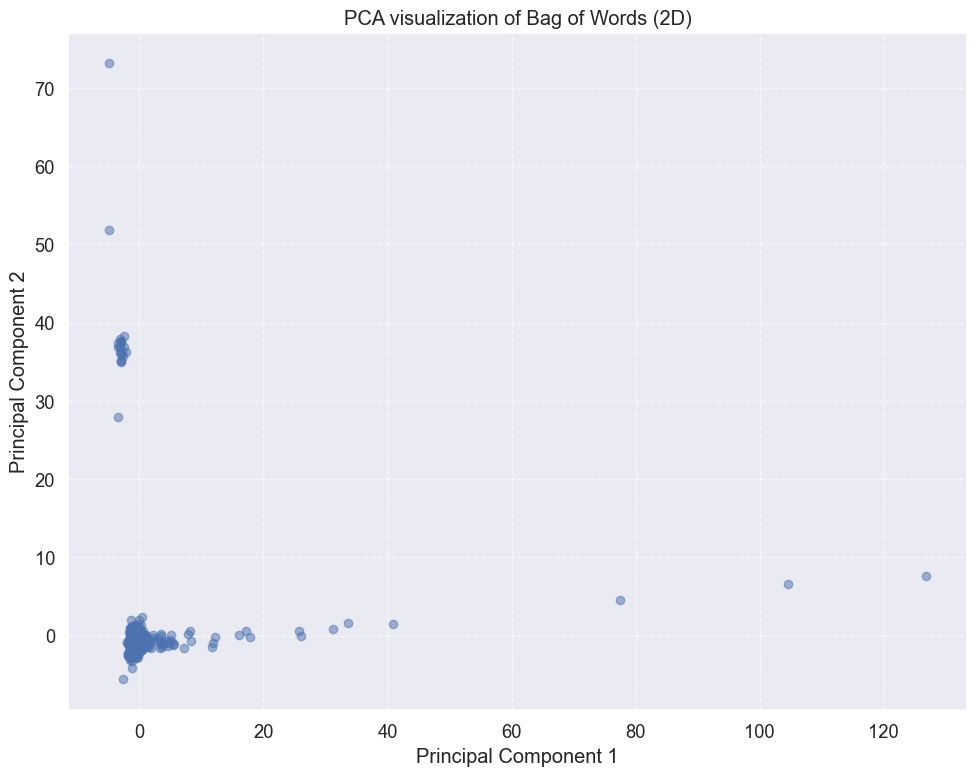

PCA explained variance ratio: 0.0151

Visualizing TF-IDF features...


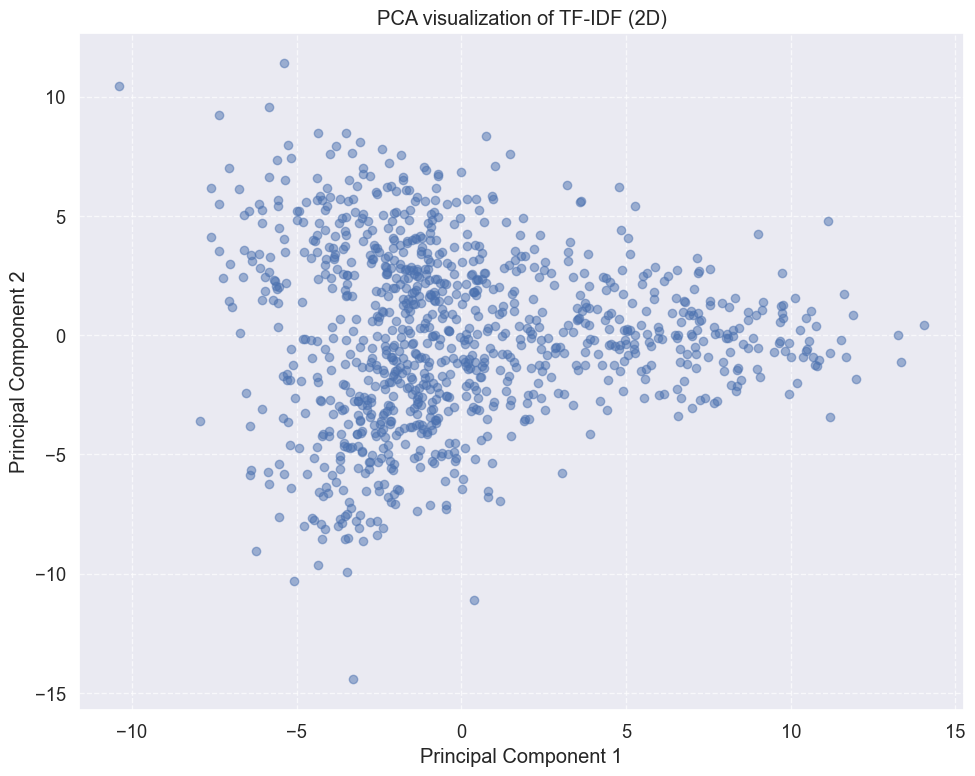

PCA explained variance ratio: 0.0063

Visualizing Word Embeddings...


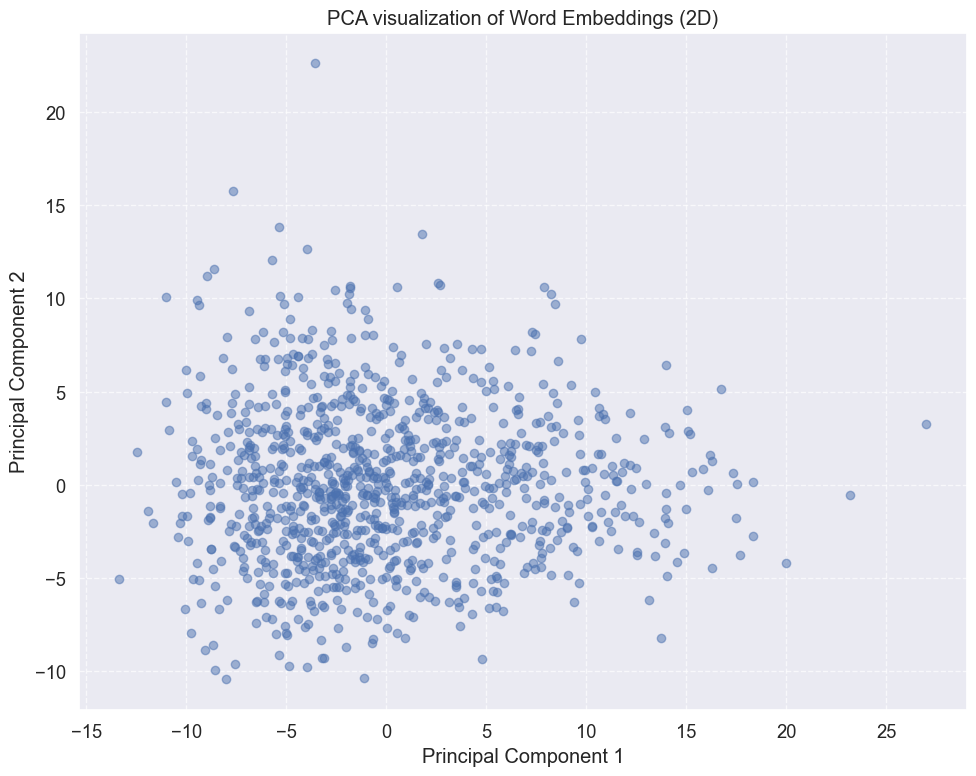

PCA explained variance ratio: 0.1867

Feature extraction and visualization complete!


In [17]:

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

print("\nVisualizing different feature representations...")

# Function to fit a dimension reduction model and plot the results
def plot_embeddings(features, title, n_samples=1000):
    # Randomly sample n_samples if there are more
    if features.shape[0] > n_samples:
        indices = np.random.choice(features.shape[0], n_samples, replace=False)
        features_sample = features[indices]
    else:
        features_sample = features
        indices = np.arange(features.shape[0])
    
    # Scale the features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features_sample)
    
    # Apply PCA for dimensionality reduction to 2D
    pca = PCA(n_components=2)
    features_pca = pca.fit_transform(features_scaled)
    
    # Create the plot
    plt.figure(figsize=(10, 8))
    plt.scatter(features_pca[:, 0], features_pca[:, 1], alpha=0.5)
    plt.title(f'PCA visualization of {title} (2D)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    print(f"PCA explained variance ratio: {pca.explained_variance_ratio_.sum():.4f}")
    
    return indices

# Visualize BoW features
if 'bow_features' in news_df.columns:
    print("\nVisualizing Bag of Words features...")
    bow_dense = bow_features.toarray()
    plot_embeddings(bow_dense, "Bag of Words")

# Visualize TF-IDF features
if 'tfidf_features' in news_df.columns:
    print("\nVisualizing TF-IDF features...")
    tfidf_dense = tfidf_features.toarray()
    plot_embeddings(tfidf_dense, "TF-IDF")

# Visualize Word Embeddings
if 'word_embeddings' in news_df.columns:
    print("\nVisualizing Word Embeddings...")
    plot_embeddings(embeddings_array, "Word Embeddings")

print("\nFeature extraction and visualization complete!")




## Cell 5: Feature Analysis - Most Discriminative Terms


In [18]:

from sklearn.feature_selection import chi2
import numpy as np
import pandas as pd

# This cell assumes you have a target variable in your DataFrame
# If you don't have one yet, you can skip this cell or adjust accordingly

print("\nAnalyzing most discriminative terms...")

# Check if we have a target column (like 'category' or 'topic')
target_column = None
potential_targets = ['category', 'topic', 'label', 'class']
for col in potential_targets:
    if col in news_df.columns:
        target_column = col
        break

if target_column is None:
    print("No target column found for feature analysis. Skipping discriminative terms analysis.")
else:
    # Convert target to numeric if needed
    if not pd.api.types.is_numeric_dtype(news_df[target_column]):
        # Create a mapping of categories to integers
        categories = news_df[target_column].unique()
        cat_to_int = {cat: i for i, cat in enumerate(categories)}
        y = news_df[target_column].map(cat_to_int)
    else:
        y = news_df[target_column]
    
    # Use TF-IDF features for this analysis
    X = tfidf_features
    
    # Calculate chi-squared stats between each feature and target
    chi2_stats, p_values = chi2(X, y)
    
    # Sort features by chi-squared statistic
    indices = np.argsort(chi2_stats)[::-1]
    
    # Display top discriminative terms for each category
    print(f"Top discriminative terms (based on chi-squared test with {target_column}):")
    
    # Get feature names
    feature_names = tfidf_vectorizer.get_feature_names_out()
    
    # Display top 20 discriminative terms overall
    print("\nTop 20 discriminative terms overall:")
    for i in indices[:20]:
        if i < len(feature_names):  # Safety check
            print(f"  {feature_names[i]}: chi²={chi2_stats[i]:.2f}, p={p_values[i]:.6f}")
    
    # If we have category labels, show top terms per category
    if not pd.api.types.is_numeric_dtype(news_df[target_column]):
        print("\nTop 10 discriminative terms per category:")
        
        for category, cat_id in cat_to_int.items():
            # Get documents in this category
            cat_docs = news_df[news_df[target_column] == category].index
            
            if len(cat_docs) > 0:
                # Calculate mean TF-IDF for each term in this category
                cat_tfidf = X[cat_docs].toarray().mean(axis=0)
                
                # Sort terms by mean TF-IDF
                cat_indices = np.argsort(cat_tfidf)[::-1]
                
                print(f"\nCategory: {category} (id={cat_id}, {len(cat_docs)} documents)")
                for i in cat_indices[:10]:
                    if i < len(feature_names):  # Safety check
                        print(f"  {feature_names[i]}: mean_tfidf={cat_tfidf[i]:.4f}")

print("\nFeature extraction and analysis complete!")


Analyzing most discriminative terms...
No target column found for feature analysis. Skipping discriminative terms analysis.

Feature extraction and analysis complete!
